In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Core packages
import warnings
warnings.filterwarnings("ignore")

# Numerical
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'  

## Single-cell packages for preprocessing and embedding
import anndata as ad

import scanpy as sc
sc.settings.verbosity = 1 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150, fontsize=10, dpi_save=150, figsize=(4, 4), format='png')
sc.settings.figdir = '.'

from scmetric.external import CSCORE, scCPCA, CPCA_cov, compute_pearson_residuals
from scmetric.pp import compute_pseudobulk


In [3]:
dataset_path = "/home/atcg/data/BD"

cohort = "McLean"
celltypes = ['Ast', 'Endo', 'Ex-L2', 'Ex-L23', 'Ex-L3', 'Ex-L45_LRRK1', 'Ex-L45_MET', 'Ex-L4_MYLK', 'Ex-L56', 'Ex-L56_CC_NTNG2', 'Ex-L5b_HTR2C', 'Ex-L6_CC_SEMA3A', 'Ex-L6b_SEMA3D', 'Ex-L6b_SEMA3E', 'In-PV_Basket', 'In-PV_Chandelier', 'In-Reelin', 'In-Rosehip_CHST9', 'In-Rosehip_TRPC3', 'In-SST', 'In-VIP', 'Mic', 'OPC', 'Oli', 'Pericytes']

mean_key="mu"
sigma2_key="sigma2"
low_var_key="has_low_variance"
corr_mat_key="corr_mat"


# Load DE genes

In [4]:
DE_tbl = pd.read_csv(f"{dataset_path}/DE_results/data_S1_BD_DEGs.csv")

DE_tbl

,cell_type,gene,logFC_McL_MASTRE,P_McL_MASTRE,FDR_McL_MASTRE,logFC_HBBC_MASTRE,P_HBBC_MASTRE,FDR_HBBC_MASTRE,logFC_Meta_MASTRE,P_Meta_hurdle_MASTRE,FDR_Meta_MASTRE,logFC_McL_NEBULA,P_McL_NEBULA,FDR_McL_NEBULA,logFC_HBBC_NEBULA,P_HBBC_NEBULA,FDR_HBBC_NEBULA,logFC_Meta_NEBULA,P_Meta_NEBULA,FDR_Meta_NEBULA,logFC_McL_edgeR,P_McL_edgeR,FDR_McL_edgeR,logFC_HBBC_edgeR,P_HBBC_edgeR,FDR_HBBC_edgeR,logFC_Meta_edgeR,P_Meta_edgeR,FDR_Meta_edgeR,bdDEG_MASTRE,bdDEG_nebula,bdDEG_edger,bdDEG_overlap
0,In-Rosehip_CHST9,A1BG,0.038257,0.268561,0.518008,-0.220656,0.000165,0.020071,0.032672,0.000488,0.008080,0.067169,0.709410,0.867603,-0.510259,0.440373,0.780640,0.027241,0.875525,0.946303,0.168979,0.417497,0.726088,-0.161826,0.959671,0.997438,0.167582,0.420375,0.748158,0,0.0,0.0,0
1,Ex-L6_CC_SEMA3A,A1BG,-0.021835,0.003515,0.035905,-0.073009,0.398696,0.722409,-0.025477,0.010610,0.064564,-0.123045,0.058388,0.216419,-0.219440,0.470647,0.797981,-0.127255,0.045312,0.178705,-0.070538,0.496705,0.780032,-0.253697,0.461785,0.878226,-0.085758,0.388155,0.725232,0,0.0,0.0,0
2,Ex-L3,A1BG,-0.060102,0.071621,0.245535,-0.007948,0.043358,0.289922,-0.022421,0.021037,0.100077,-0.187935,0.007880,0.057073,-0.192455,0.589895,0.859570,-0.188106,0.006703,0.049295,-0.079157,0.471969,0.764046,-0.151317,0.737933,0.957139,-0.083191,0.436571,0.758791,0,0.0,0.0,0
3,Ex-L2,A1BG,-0.028618,0.228149,0.474692,-0.006097,0.068091,0.353534,-0.014917,0.080233,0.228025,-0.102110,0.182697,0.427890,-0.068951,0.777951,0.934335,-0.099144,0.175148,0.410262,-0.062576,0.526423,0.798369,-0.303302,0.289602,0.795731,-0.088167,0.345095,0.692119,0,0.0,0.0,0
4,Ex-L56,A1BG,-0.028818,0.269611,0.519102,-1.775938,0.072712,0.363855,-0.030753,0.096687,0.255034,-0.138496,0.373425,0.633120,-1.264275,0.089490,0.423412,-0.185609,0.222983,0.471031,-0.092672,0.654607,0.868729,0.208558,0.299843,0.801866,0.062359,0.665663,0.883504,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320555,Mic,ZZEF1,-0.418428,0.163215,0.394558,0.126733,0.578891,0.826929,-0.013177,0.317402,0.513679,-0.151744,0.141525,0.369577,0.051421,0.326997,0.703715,0.009713,0.835466,0.927288,0.071193,0.608121,0.845147,0.016759,0.808948,0.972348,0.027618,0.656066,0.879256,0,0.0,0.0,0
320556,Endo,ZZEF1,-0.791037,0.231560,0.478294,0.180877,0.570063,0.822268,0.041870,0.399301,0.586913,-0.301602,0.144689,0.374175,0.078444,0.213239,0.601434,0.046143,0.444020,0.683851,-0.359005,0.055737,0.278865,-0.004194,0.968302,0.998609,-0.089449,0.330848,0.680633,0,0.0,0.0,0
320557,Oli,ZZEF1,-0.099646,0.317705,0.565973,-0.015908,0.935875,0.979180,-0.074215,0.657967,0.781635,-0.058053,0.081265,0.265714,-0.022127,0.604431,0.866230,-0.044473,0.090370,0.276718,-0.028623,0.490879,0.776320,-0.019112,0.709473,0.950975,-0.024855,0.441398,0.762048,0,0.0,0.0,0
320558,In-Rosehip_TRPC3,ZZEF1,-0.124980,0.702638,0.846403,-0.119502,0.612880,0.843861,-0.121751,0.793441,0.870760,-0.106380,0.016551,0.094905,-0.031863,0.419744,0.768123,-0.064783,0.028111,0.130624,-0.100552,0.122376,0.414548,-0.024024,0.617381,0.928546,-0.051049,0.186891,0.535344,0,0.0,0.0,0


# Load sample annotations

In [5]:
metadata_tbl = pd.read_csv(f"{dataset_path}/McLean/Demographics&Meds_SZ_CON_BD.csv")
metadata_tbl = metadata_tbl.sort_values(by=["Batch", "HTO"])
metadata_tbl.index = [metadata_tbl["Batch"].iloc[i].replace("McLean_", "") + "_" + metadata_tbl["HTO"].iloc[i].replace("McLean_", "") for i in range(metadata_tbl.shape[0])]
metadata_tbl = metadata_tbl.loc[metadata_tbl["Phenotype"] != "SZ", :].copy()

metadata_tbl["Antipsych"] = ((metadata_tbl["AntipsychTyp"] + metadata_tbl["AntipsychAtyp"]) > 0).astype(int)
metadata_tbl["Medication"] = pd.DataFrame({med:pd.Categorical(["-", med])[metadata_tbl.loc[:, med]].astype(str) for med in ['Anticonvulsants', 'Antipsych', 'Lithium']}).agg(', '.join, axis=1).values
metadata_tbl.loc[(metadata_tbl["Phenotype"] == "CON") & (metadata_tbl["Medication"] == "-, -, -"), "Medication"] = "NoMed (CON)"
metadata_tbl.loc[(metadata_tbl["Phenotype"] == "BD") & (metadata_tbl["Medication"] == "-, -, -"), "Medication"] = "NoMed (BD)"

# metadata_tbl["Medication"].value_counts()

# choices=pd.Series(["No", "Yes"])
# for col in ['Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp', 'Lithium']:
#     metadata_tbl.loc[:, col] = pd.Series(pd.Categorical(choices[metadata_tbl[col]], categories = choices), index = metadata_tbl.index)

metadata_tbl


,ID,Cohort,Phenotype,Batch,HTO,Gender,Age,PMI,Benzodiazepines,Anticonvulsants,AntipsychTyp,AntipsychAtyp,Antidepress,Lithium,Antipsych,Medication
Batch1_HTO1,BD1,McLean,BD,McLean_Batch1,McLean_HTO1,Female,73,17.00,1,1,0,1,1,1,1,"Anticonvulsants, Antipsych, Lithium"
Batch1_HTO2,BD2,McLean,BD,McLean_Batch1,McLean_HTO2,Female,80,27.08,0,1,1,0,1,1,1,"Anticonvulsants, Antipsych, Lithium"
Batch1_HTO4,BD3,McLean,BD,McLean_Batch1,McLean_HTO4,Male,24,24.70,0,0,0,0,0,0,0,NoMed (BD)
Batch1_HTO7,CON1,McLean,CON,McLean_Batch1,McLean_HTO7,Female,72,18.25,0,0,0,0,0,0,0,NoMed (CON)
Batch1_HTO8,CON2,McLean,CON,McLean_Batch1,McLean_HTO8,Male,88,11.06,0,0,0,0,0,0,0,NoMed (CON)
Batch1_HTO9,CON3,McLean,CON,McLean_Batch1,McLean_HTO9,Female,68,11.50,0,0,0,0,0,0,0,NoMed (CON)
Batch2_HTO3,BD4,McLean,BD,McLean_Batch2,McLean_HTO3,Female,76,22.80,1,0,0,0,0,1,0,"-, -, Lithium"
Batch2_HTO4,BD5,McLean,BD,McLean_Batch2,McLean_HTO4,Male,71,16.08,0,1,1,0,1,0,1,"Anticonvulsants, Antipsych, -"
Batch2_HTO5,CON4,McLean,CON,McLean_Batch2,McLean_HTO5,Male,52,7.83,0,0,0,0,0,0,0,NoMed (CON)
Batch2_HTO6,CON5,McLean,CON,McLean_Batch2,McLean_HTO6,Male,36,21.46,0,0,0,0,0,0,0,NoMed (CON)


# Perform contrastive analysis

Ast
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.07e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.74e-03).
iter 1: alpha=1.01e+00, target_var=1.71e+02, background_var=1.69e+02, contrastive_var=1.73e-01
iter 2: alpha=2.01e+00, target_var=1.12e+02, background_var=5.54e+01, contrastive_var=2.26e-01
iter 3: alpha=3.62e+00, target_var=5.73e+01, background_var=1.58e+01, contrastive_var=2.08e-01
iter 4: alpha=6.89e+00, target_var=2.67e+01, background_var=3.85e+00, contrastive_var=1.84e-01
iter 5: alpha=1.81e+01, target_var=1.15e+01, background_var=6.26e-01, contrastive_var=2.09e-01
iter 6: alpha=2.33e+01, target_var=9.30e+00, background_var=3.89e-01, contrastive_var=2.17e-01
aggregating on .X attribute since no layer specified


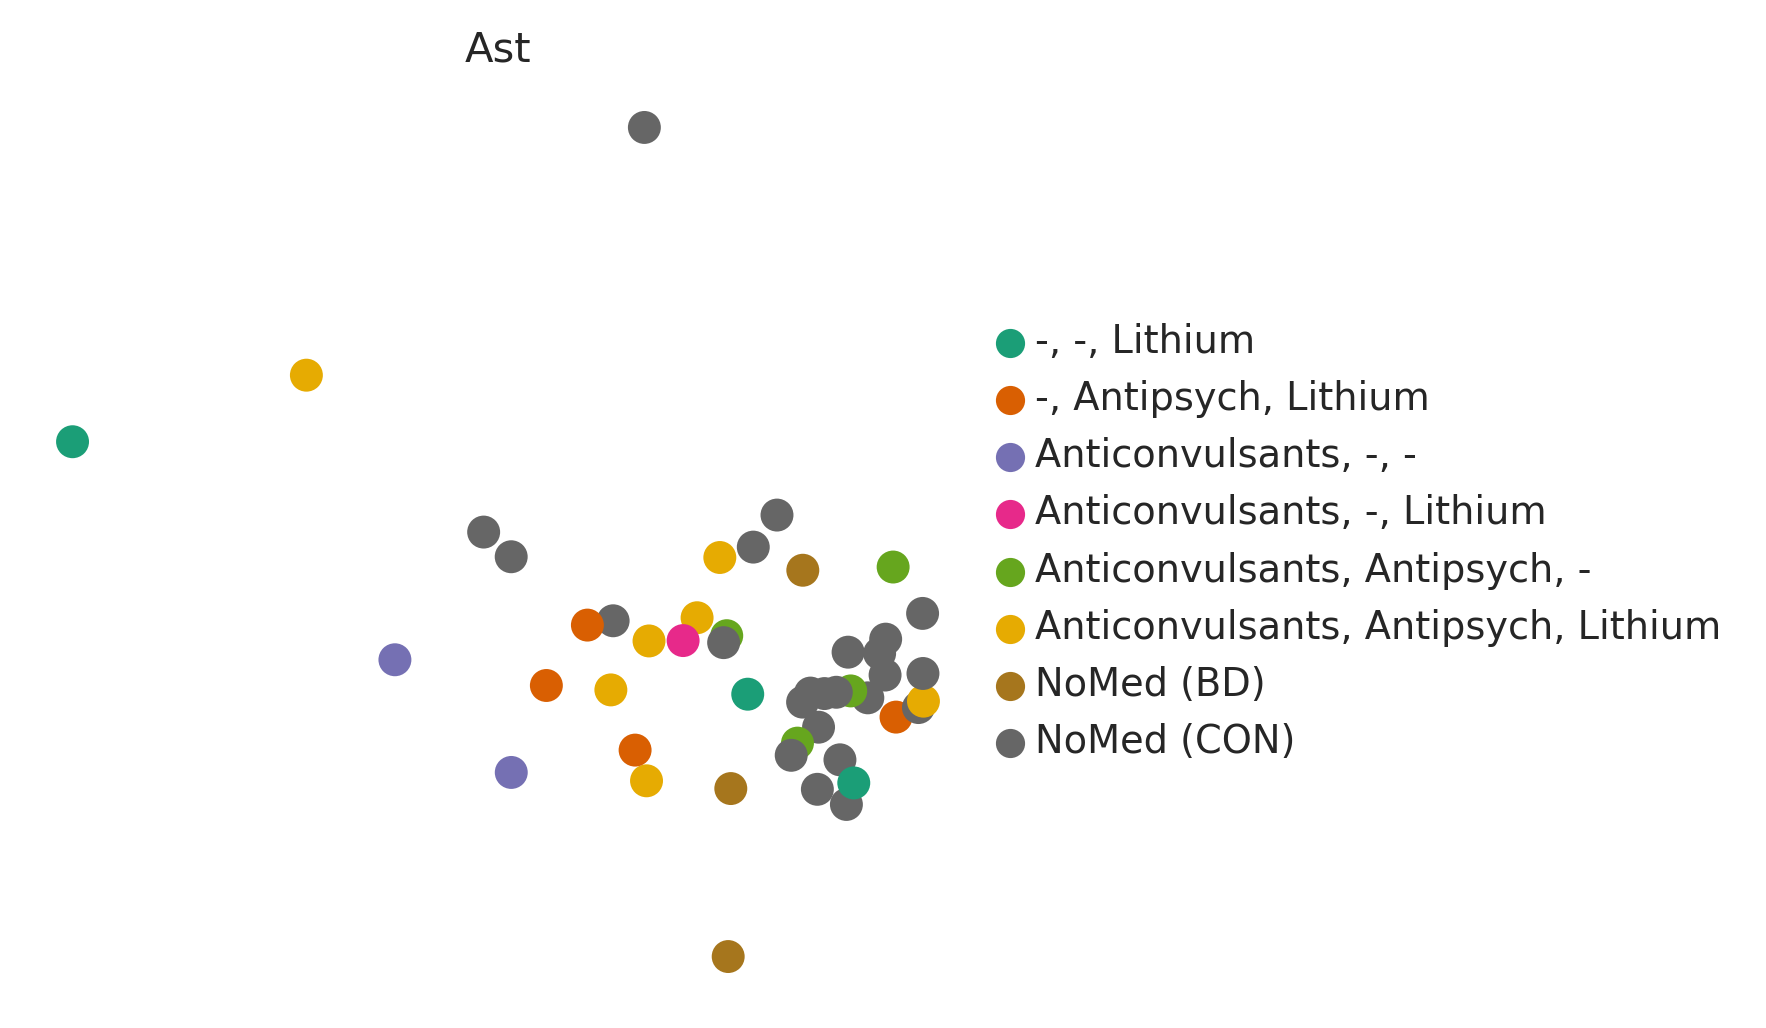

Endo
Iteration 0
Iteration 1
Iteration 2
Iteration 3
IRLS converged after 4 iterations (delta=5.61e-03).
Iteration 0
Iteration 1
Iteration 2
Iteration 3
IRLS converged after 4 iterations (delta=1.30e-03).
iter 1: alpha=1.27e+00, target_var=1.14e+02, background_var=8.93e+01, contrastive_var=1.44e-01
iter 2: alpha=6.47e+00, target_var=8.75e+01, background_var=1.34e+01, contrastive_var=5.67e-01
iter 3: alpha=4.02e+01, target_var=5.82e+01, background_var=1.39e+00, contrastive_var=2.34e+00
iter 4: alpha=3.95e+02, target_var=4.19e+01, background_var=6.42e-02, contrastive_var=1.65e+01
iter 5: alpha=9.72e+02, target_var=3.70e+01, background_var=1.05e-03, contrastive_var=3.59e+01
iter 6: alpha=9.95e+02, target_var=3.65e+01, background_var=1.87e-04, contrastive_var=3.63e+01
aggregating on .X attribute since no layer specified


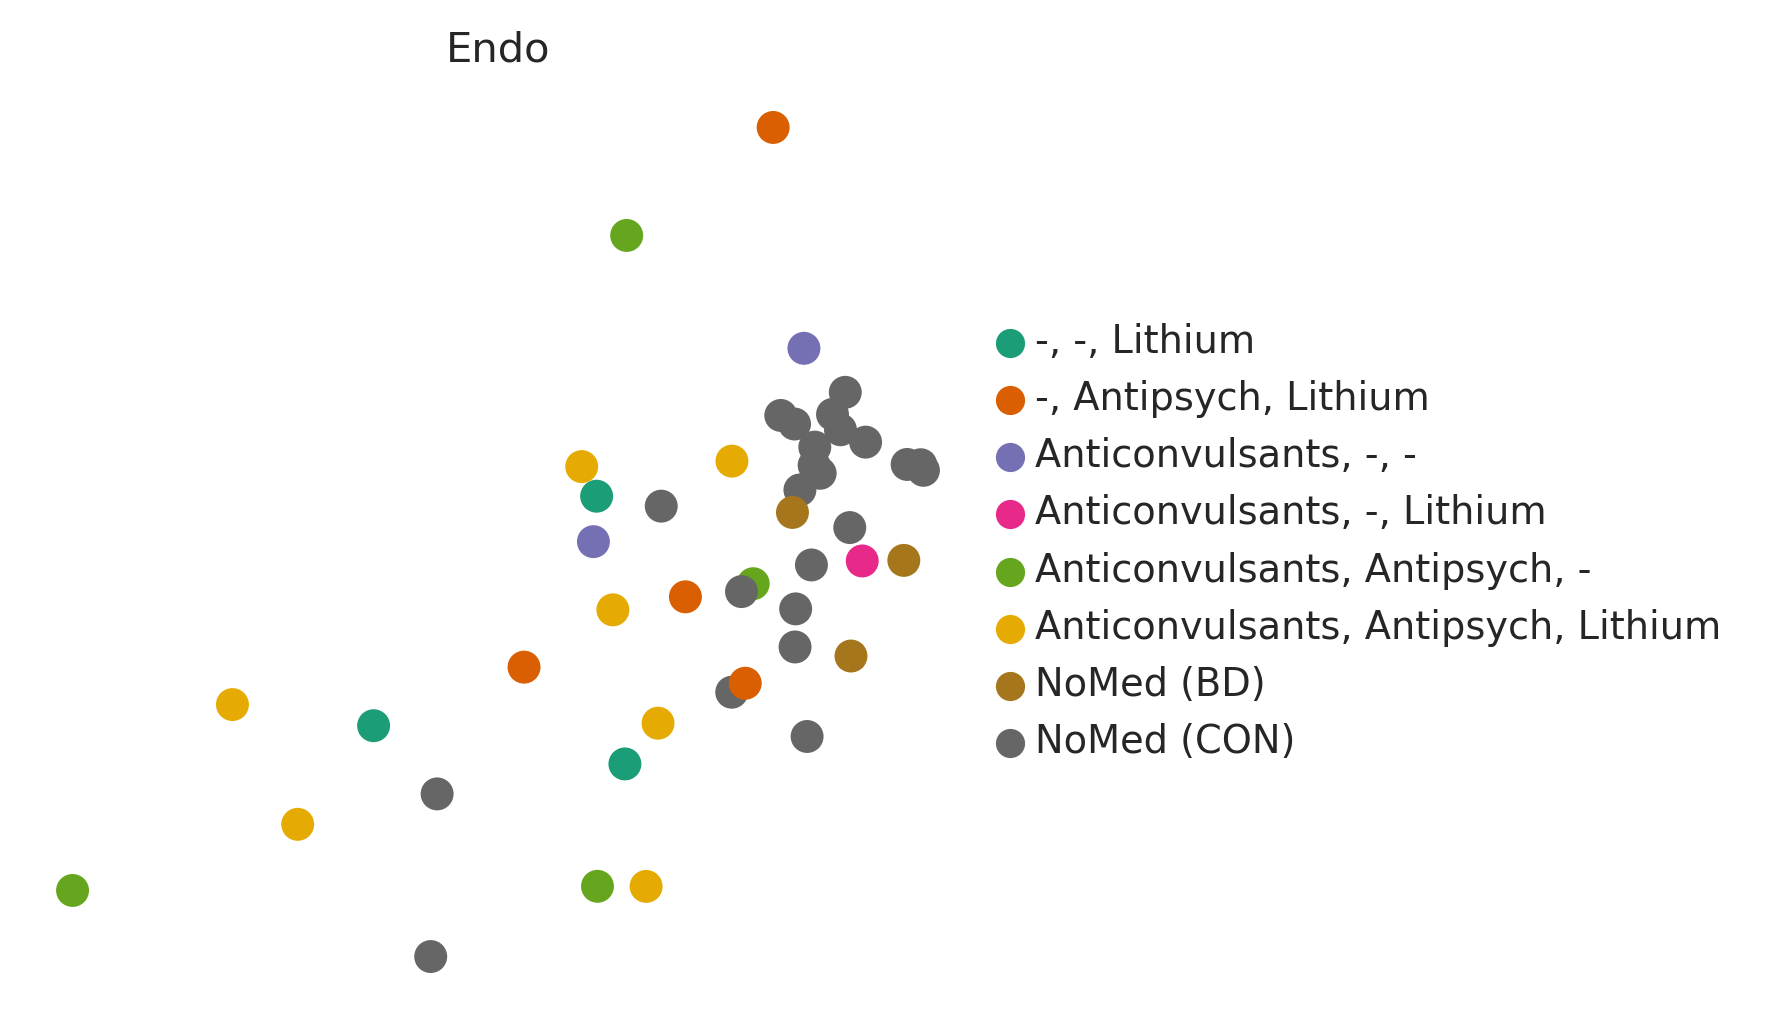

Ex-L2
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.74e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.34e-03).
iter 1: alpha=1.40e+00, target_var=9.98e+02, background_var=7.14e+02, contrastive_var=1.39e+00
iter 2: alpha=4.80e+00, target_var=7.07e+02, background_var=1.47e+02, contrastive_var=3.40e+00
iter 3: alpha=2.58e+01, target_var=4.13e+02, background_var=1.56e+01, contrastive_var=1.07e+01
iter 4: alpha=2.87e+02, target_var=2.89e+02, background_var=7.18e-01, contrastive_var=8.28e+01
iter 5: alpha=9.68e+02, target_var=2.53e+02, background_var=8.44e-03, contrastive_var=2.45e+02
iter 6: alpha=9.97e+02, target_var=2.50e+02, background_var=8.28e-04, contrastive_var=2.49e+02
aggregating on .X attribute since no layer specified


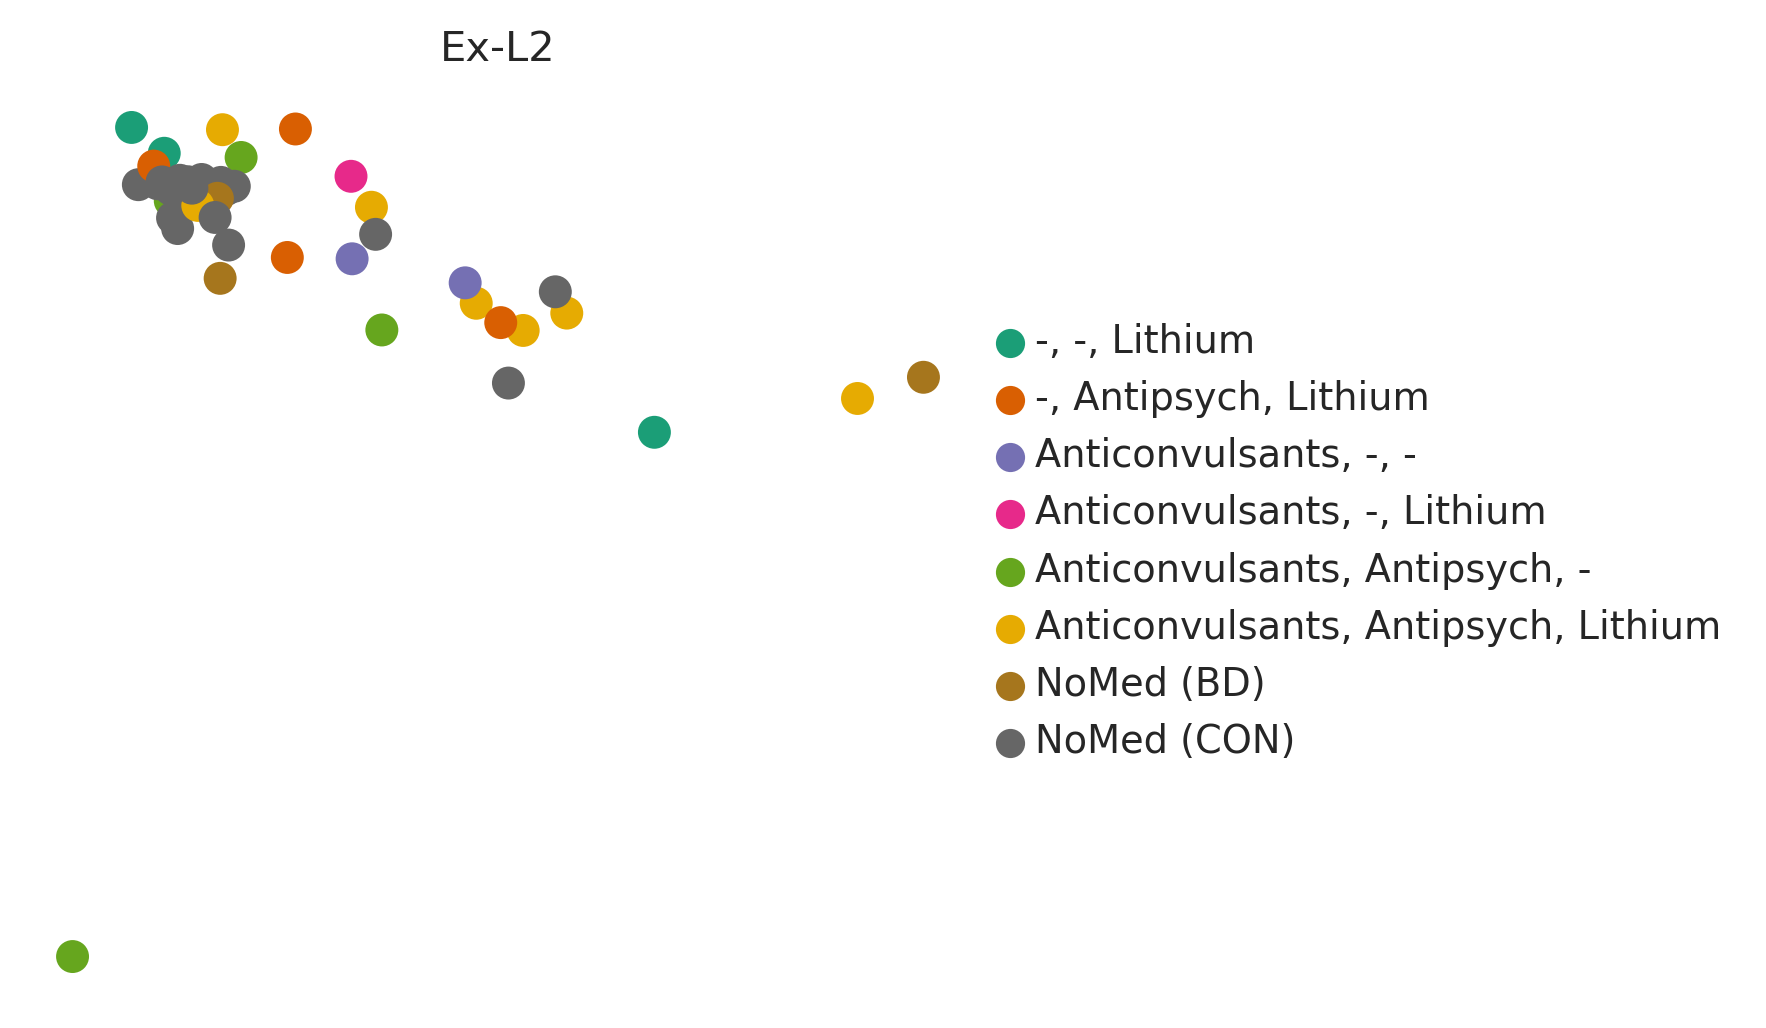

Ex-L23
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=4.79e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=7.17e-04).
iter 1: alpha=1.18e+00, target_var=8.71e+02, background_var=7.35e+02, contrastive_var=1.03e+00
iter 2: alpha=2.83e+00, target_var=5.86e+02, background_var=2.07e+02, contrastive_var=1.66e+00
iter 3: alpha=8.00e+00, target_var=2.97e+02, background_var=3.68e+01, contrastive_var=2.38e+00
iter 4: alpha=3.67e+01, target_var=1.62e+02, background_var=4.26e+00, contrastive_var=5.96e+00
iter 5: alpha=3.66e+02, target_var=1.09e+02, background_var=1.89e-01, contrastive_var=4.00e+01
iter 6: alpha=9.80e+02, target_var=9.62e+01, background_var=1.96e-03, contrastive_var=9.43e+01
iter 7: alpha=9.97e+02, target_var=9.53e+01, background_var=2.86e-04, contrastive_var=9.50e+01
aggregating on .X attribute since no layer specified


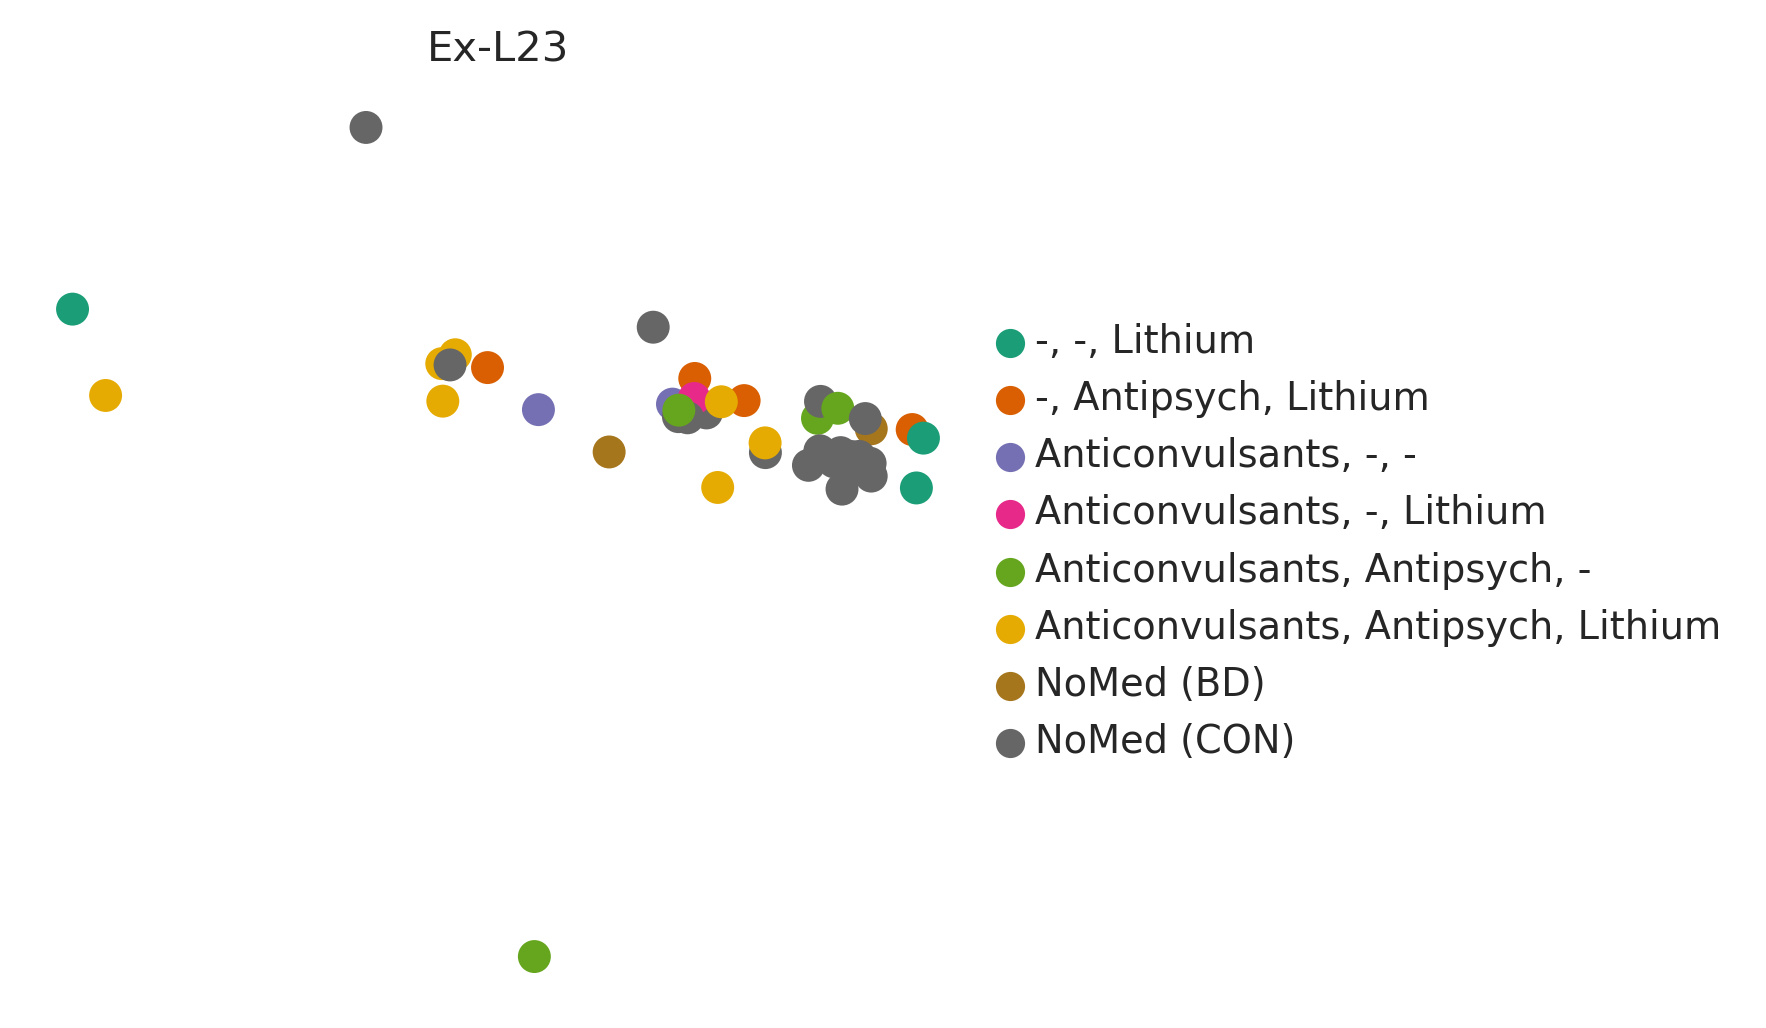

Ex-L3
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=9.86e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=8.20e-04).
iter 1: alpha=1.59e+00, target_var=1.14e+03, background_var=7.12e+02, contrastive_var=1.81e+00
iter 2: alpha=5.18e+00, target_var=7.84e+02, background_var=1.51e+02, contrastive_var=4.06e+00
iter 3: alpha=2.41e+01, target_var=4.51e+02, background_var=1.83e+01, contrastive_var=1.09e+01
iter 4: alpha=2.23e+02, target_var=3.01e+02, background_var=1.05e+00, contrastive_var=6.69e+01
iter 5: alpha=9.41e+02, target_var=2.54e+02, background_var=1.60e-02, contrastive_var=2.39e+02
iter 6: alpha=9.96e+02, target_var=2.48e+02, background_var=1.02e-03, contrastive_var=2.47e+02
aggregating on .X attribute since no layer specified


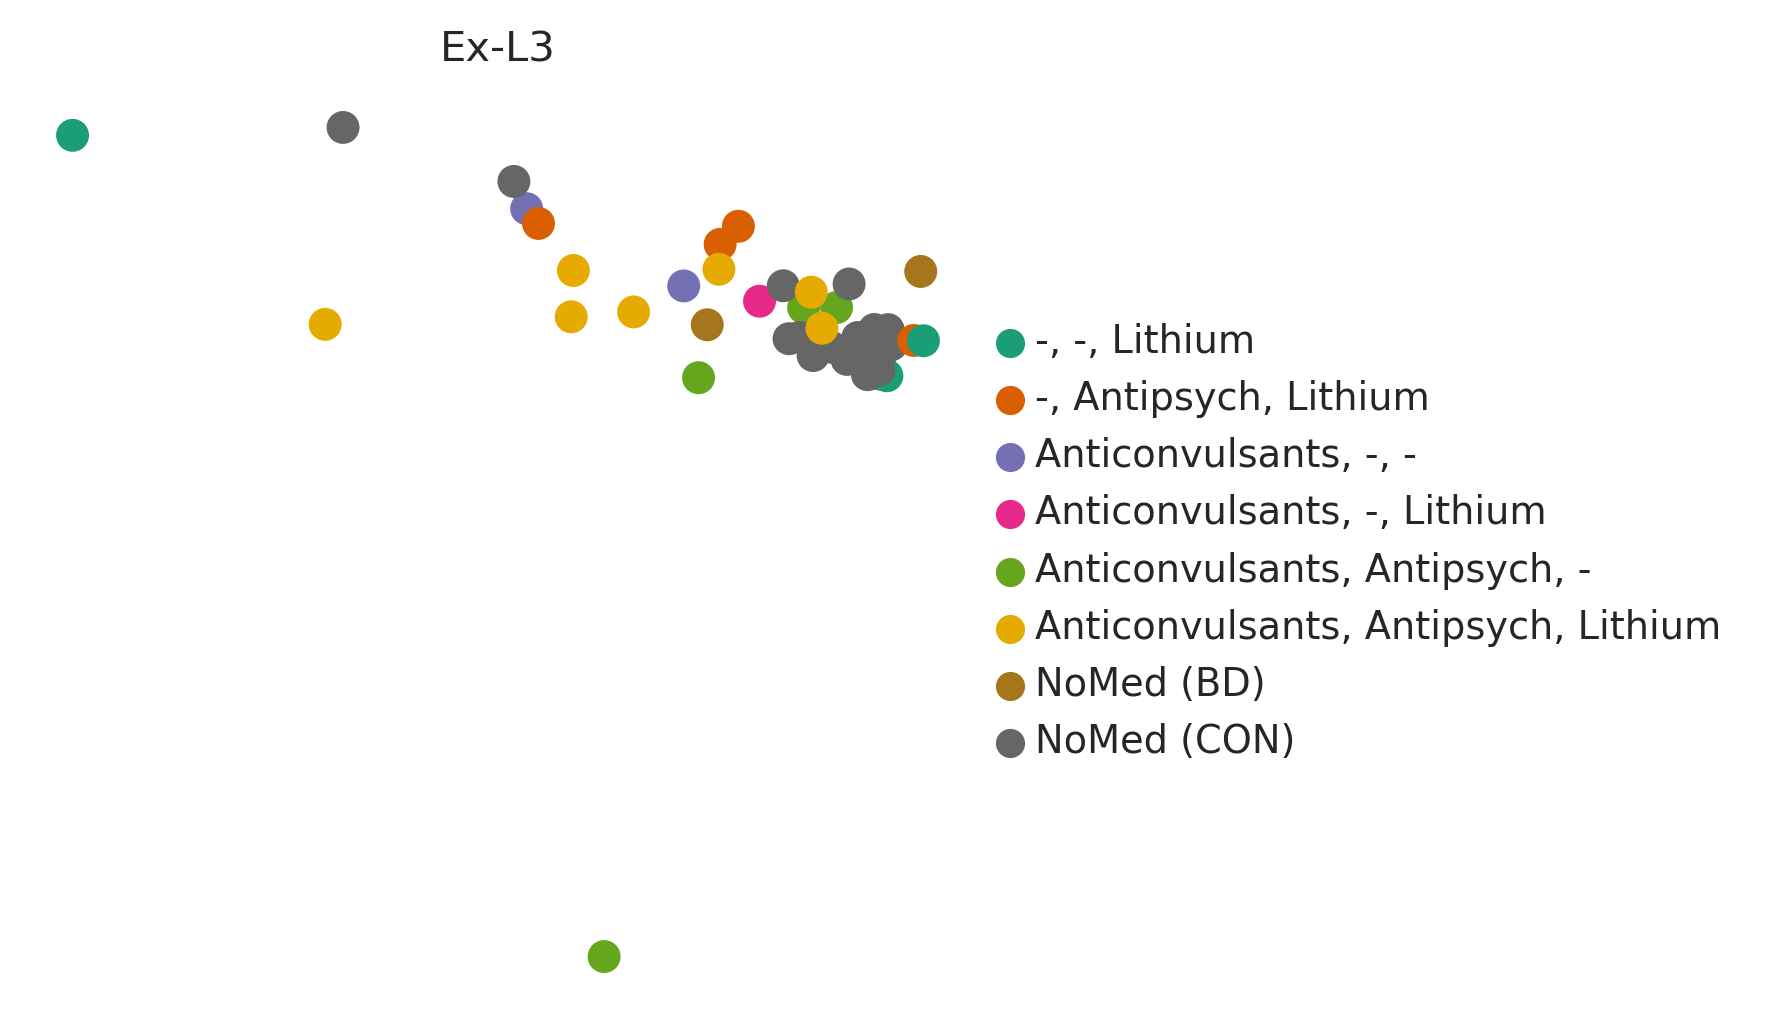

Ex-L45_LRRK1
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.93e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.74e-03).
iter 1: alpha=1.39e+00, target_var=1.16e+03, background_var=8.31e+02, contrastive_var=1.60e+00
iter 2: alpha=4.02e+00, target_var=7.86e+02, background_var=1.95e+02, contrastive_var=3.16e+00
iter 3: alpha=1.51e+01, target_var=4.29e+02, background_var=2.81e+01, contrastive_var=6.47e+00
iter 4: alpha=1.10e+02, target_var=2.64e+02, background_var=2.15e+00, contrastive_var=2.90e+01
iter 5: alpha=8.12e+02, target_var=2.08e+02, background_var=4.83e-02, contrastive_var=1.69e+02
iter 6: alpha=9.94e+02, target_var=1.99e+02, background_var=1.17e-03, contrastive_var=1.98e+02
aggregating on .X attribute since no layer specified


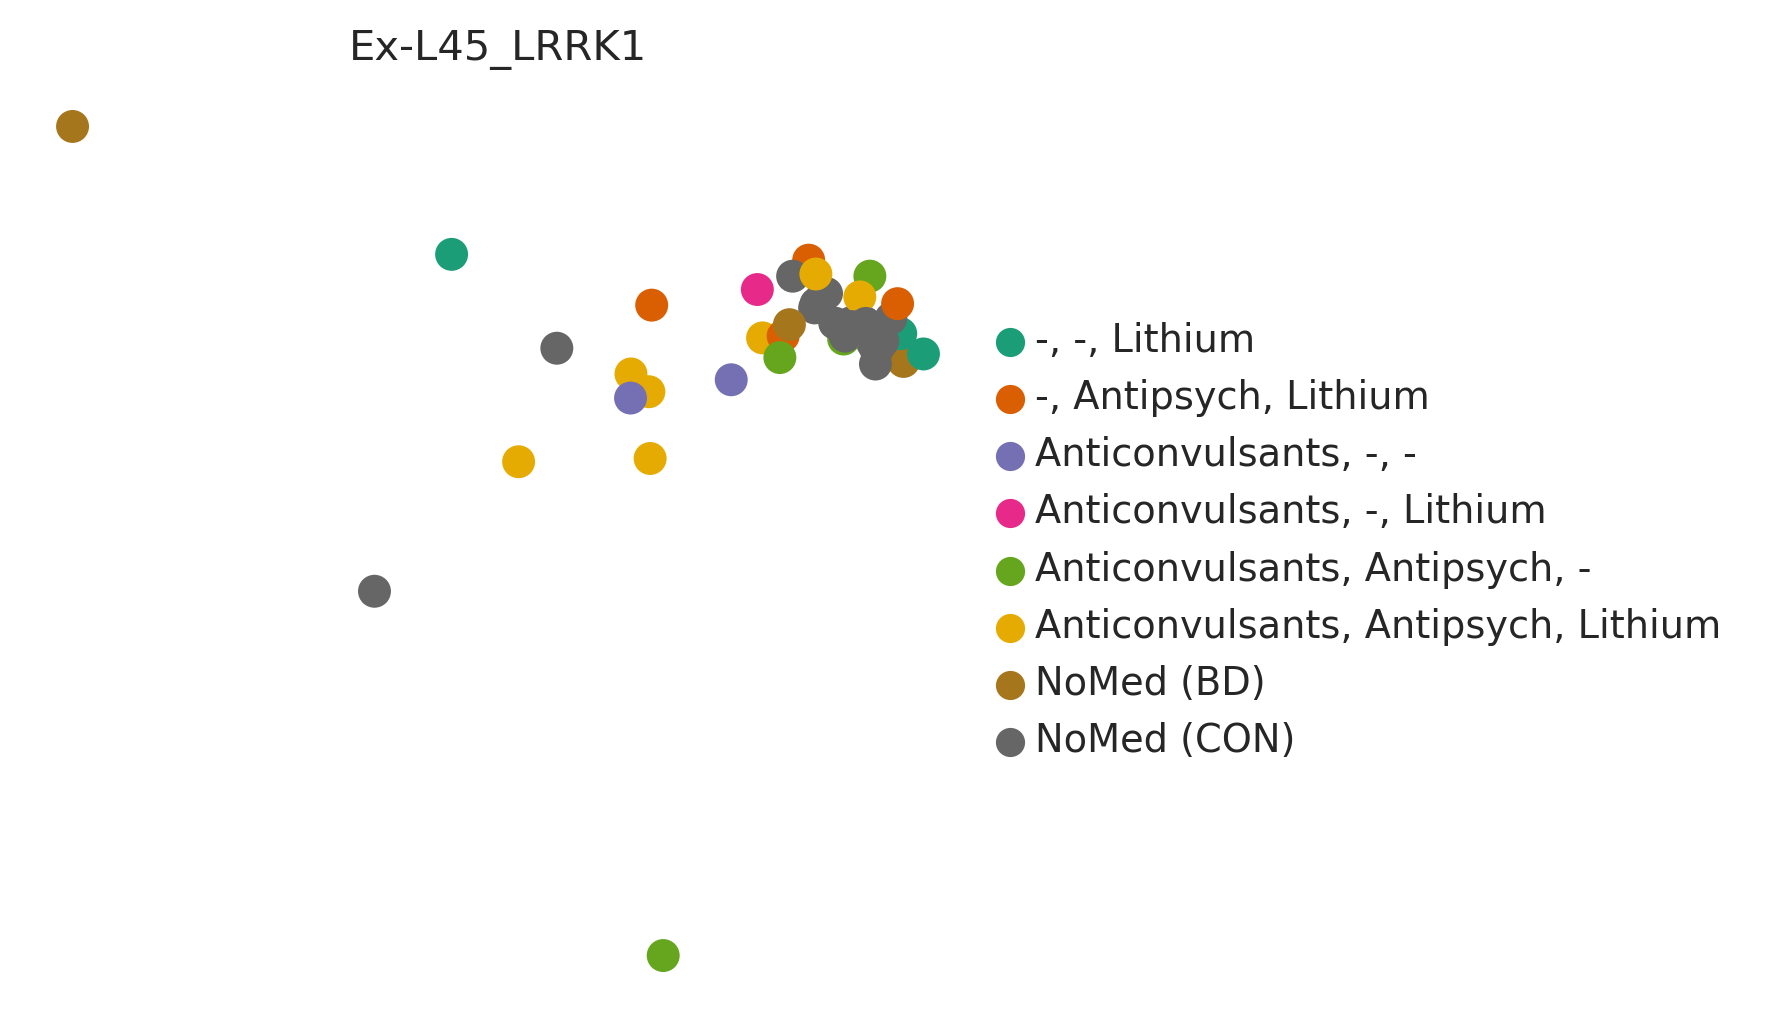

Ex-L45_MET
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=9.07e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=2.11e-03).
iter 1: alpha=1.59e+00, target_var=1.14e+03, background_var=7.14e+02, contrastive_var=1.82e+00
iter 2: alpha=5.69e+00, target_var=7.89e+02, background_var=1.38e+02, contrastive_var=4.49e+00
iter 3: alpha=2.95e+01, target_var=4.70e+02, background_var=1.55e+01, contrastive_var=1.38e+01
iter 4: alpha=3.06e+02, target_var=3.25e+02, background_var=7.38e-01, contrastive_var=9.93e+01
iter 5: alpha=9.69e+02, target_var=2.84e+02, background_var=9.05e-03, contrastive_var=2.75e+02
iter 6: alpha=9.97e+02, target_var=2.80e+02, background_var=9.78e-04, contrastive_var=2.79e+02
aggregating on .X attribute since no layer specified


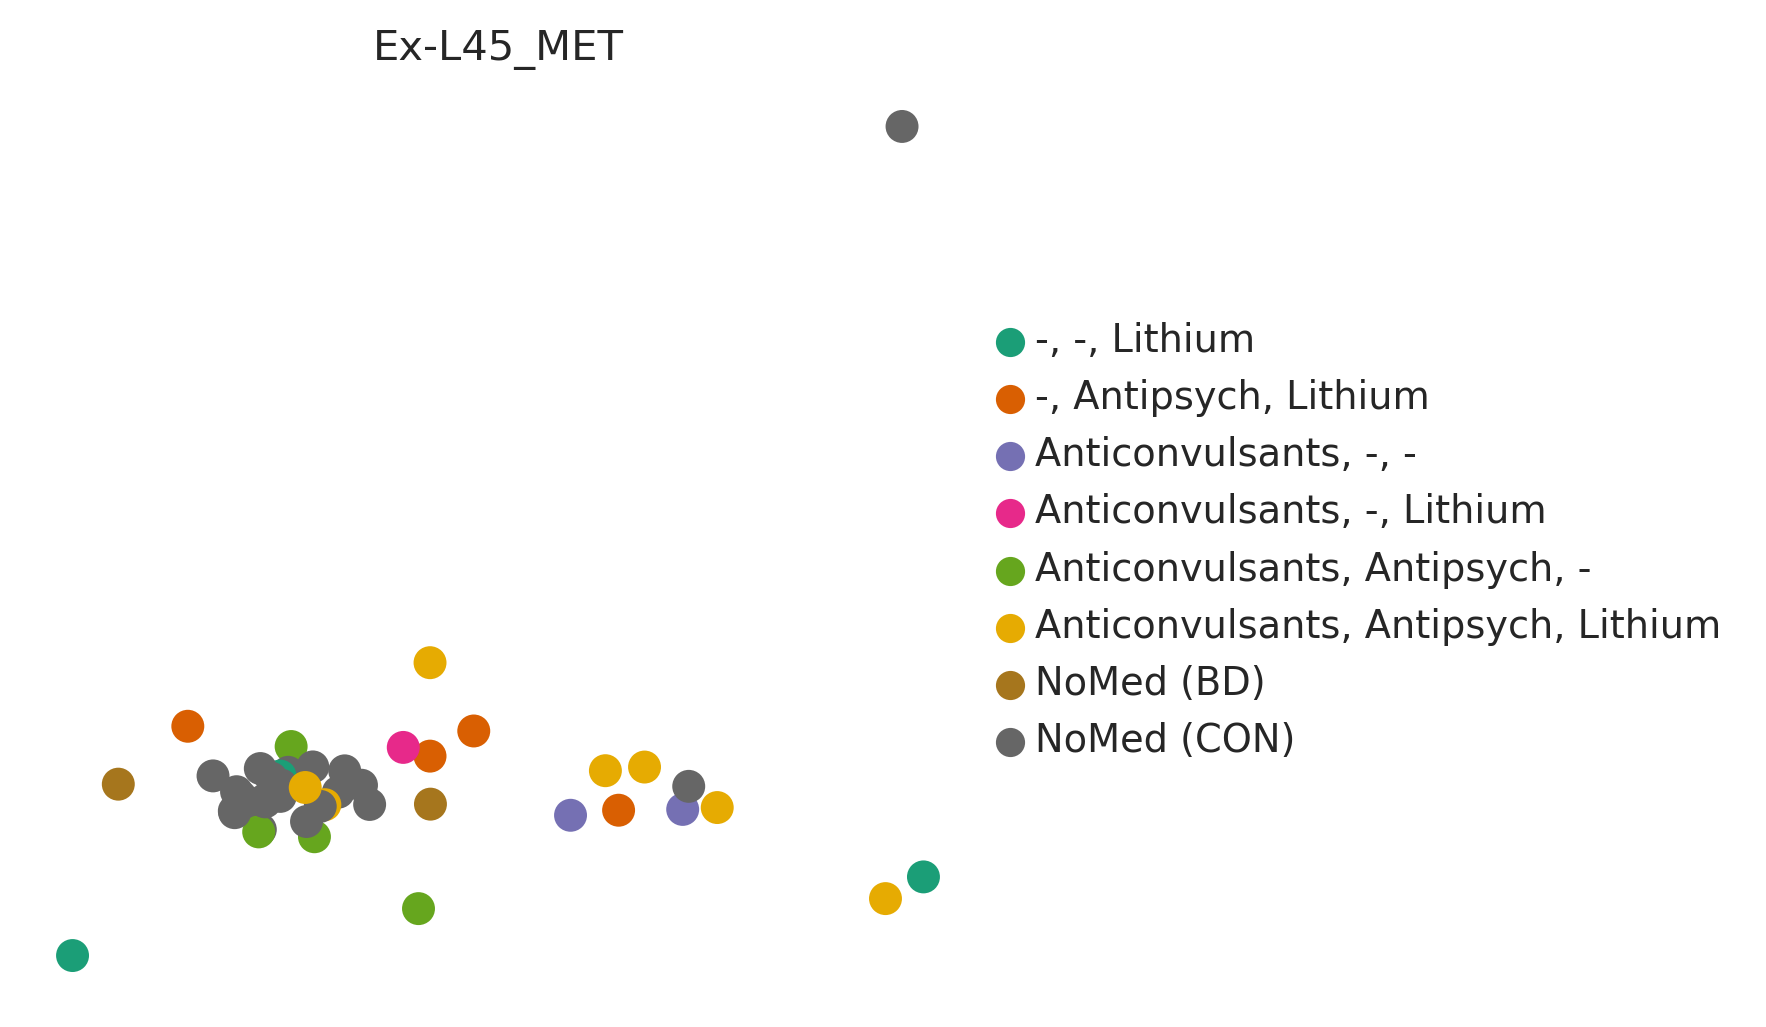

Ex-L4_MYLK
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.23e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.23e-03).
iter 1: alpha=1.45e+00, target_var=3.54e+02, background_var=2.44e+02, contrastive_var=5.12e-01
iter 2: alpha=4.41e+00, target_var=2.45e+02, background_var=5.53e+01, contrastive_var=1.08e+00
iter 3: alpha=1.63e+01, target_var=1.36e+02, background_var=8.24e+00, contrastive_var=2.22e+00
iter 4: alpha=1.29e+02, target_var=8.27e+01, background_var=5.56e-01, contrastive_var=1.07e+01
iter 5: alpha=8.69e+02, target_var=6.63e+01, background_var=1.00e-02, contrastive_var=5.76e+01
iter 6: alpha=9.96e+02, target_var=6.40e+01, background_var=2.50e-04, contrastive_var=6.38e+01
aggregating on .X attribute since no layer specified


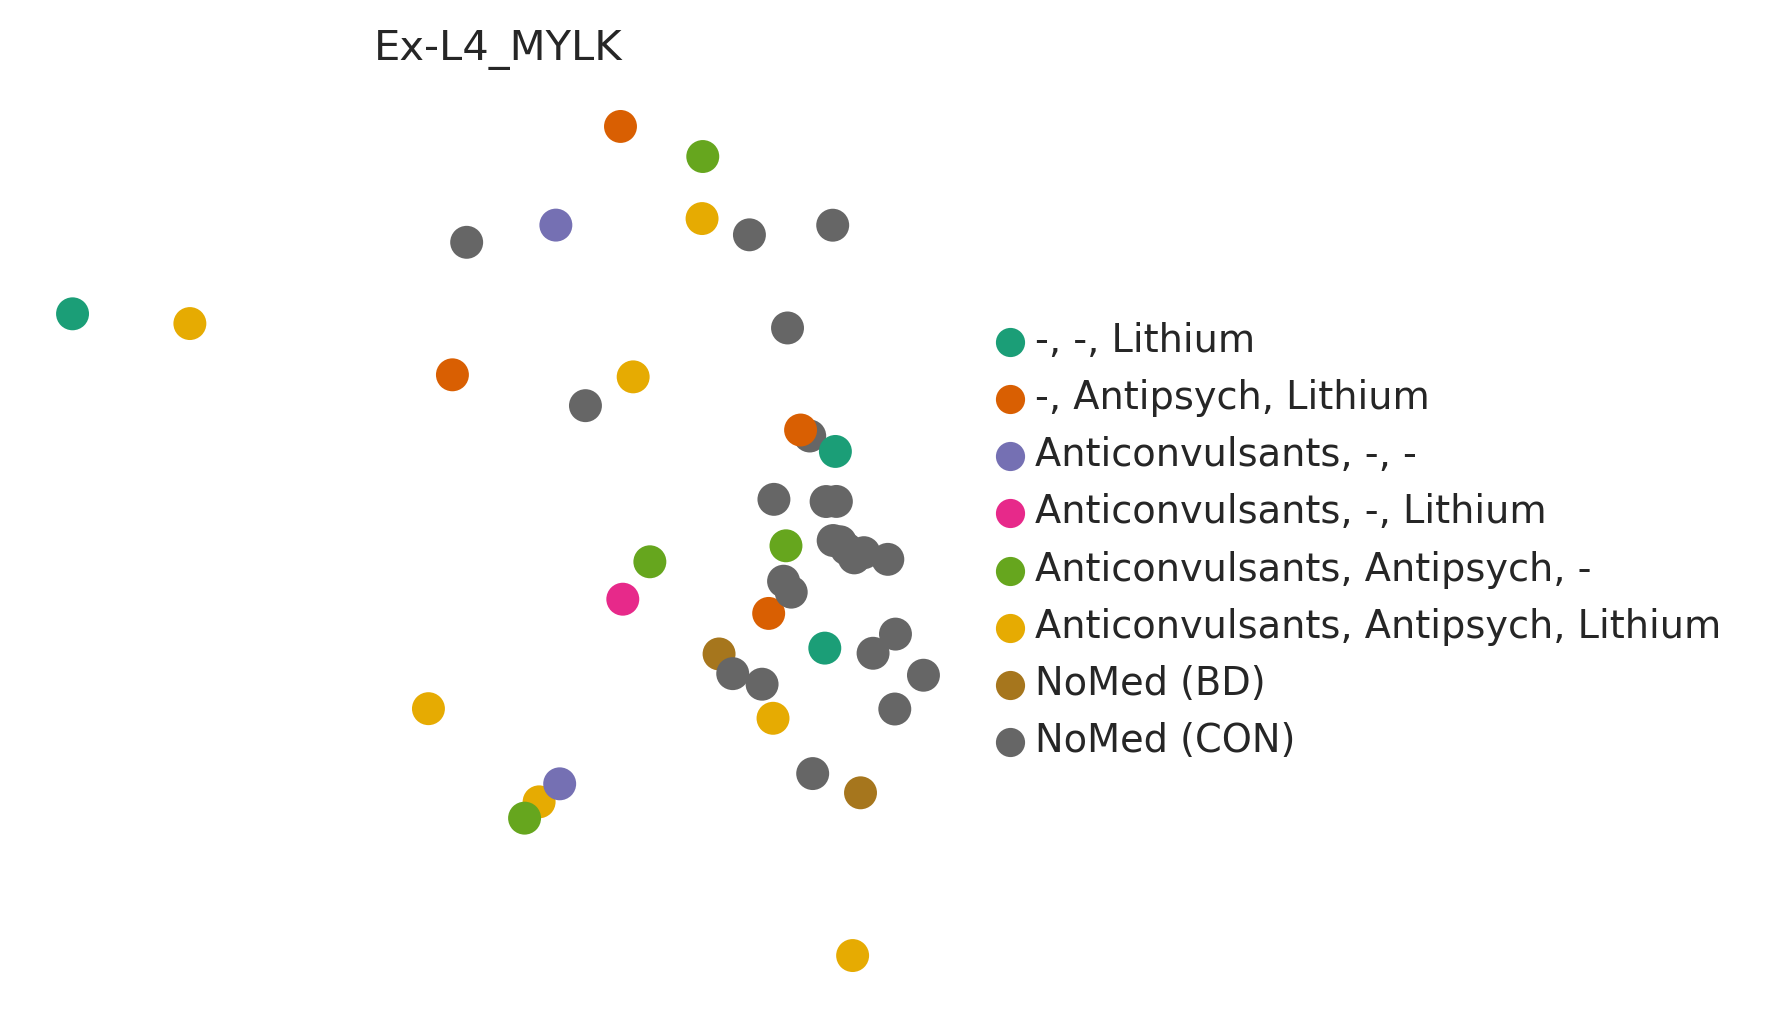

Ex-L56
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.15e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=4.73e-03).
iter 1: alpha=1.58e+00, target_var=2.97e+02, background_var=1.88e+02, contrastive_var=4.69e-01
iter 2: alpha=4.93e+00, target_var=2.05e+02, background_var=4.13e+01, contrastive_var=1.01e+00
iter 3: alpha=2.01e+01, target_var=1.15e+02, background_var=5.60e+00, contrastive_var=2.31e+00
iter 4: alpha=1.71e+02, target_var=7.33e+01, background_var=3.54e-01, contrastive_var=1.26e+01
iter 5: alpha=9.08e+02, target_var=6.04e+01, background_var=6.08e-03, contrastive_var=5.49e+01
iter 6: alpha=9.96e+02, target_var=5.87e+01, background_var=2.48e-04, contrastive_var=5.84e+01
aggregating on .X attribute since no layer specified


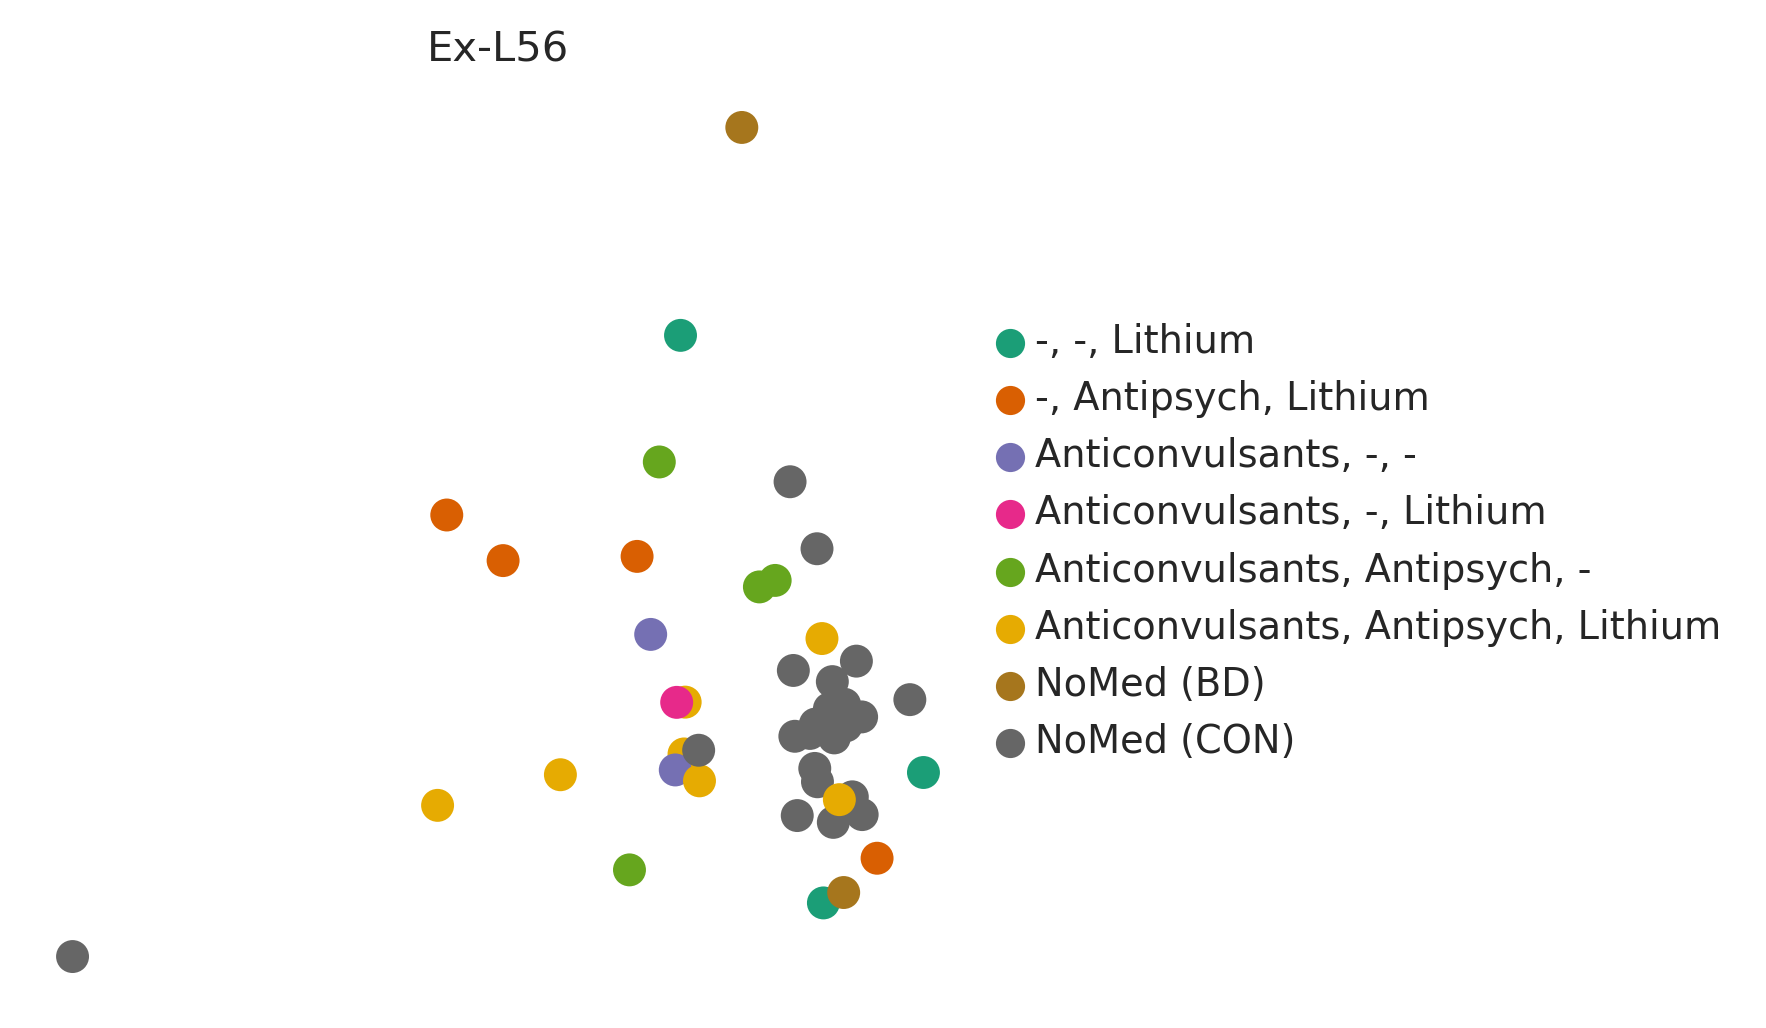

Ex-L56_CC_NTNG2
Iteration 0
Iteration 1
IRLS converged after 2 iterations (delta=9.02e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=7.64e-04).
iter 1: alpha=1.56e+00, target_var=4.71e+02, background_var=3.02e+02, contrastive_var=7.34e-01
iter 2: alpha=5.87e+00, target_var=3.32e+02, background_var=5.63e+01, contrastive_var=1.95e+00
iter 3: alpha=3.40e+01, target_var=2.01e+02, background_var=5.72e+00, contrastive_var=6.85e+00
iter 4: alpha=3.83e+02, target_var=1.44e+02, background_var=2.32e-01, contrastive_var=5.53e+01
iter 5: alpha=9.78e+02, target_var=1.29e+02, background_var=2.85e-03, contrastive_var=1.26e+02
iter 6: alpha=9.96e+02, target_var=1.28e+02, background_var=4.87e-04, contrastive_var=1.27e+02
aggregating on .X attribute since no layer specified


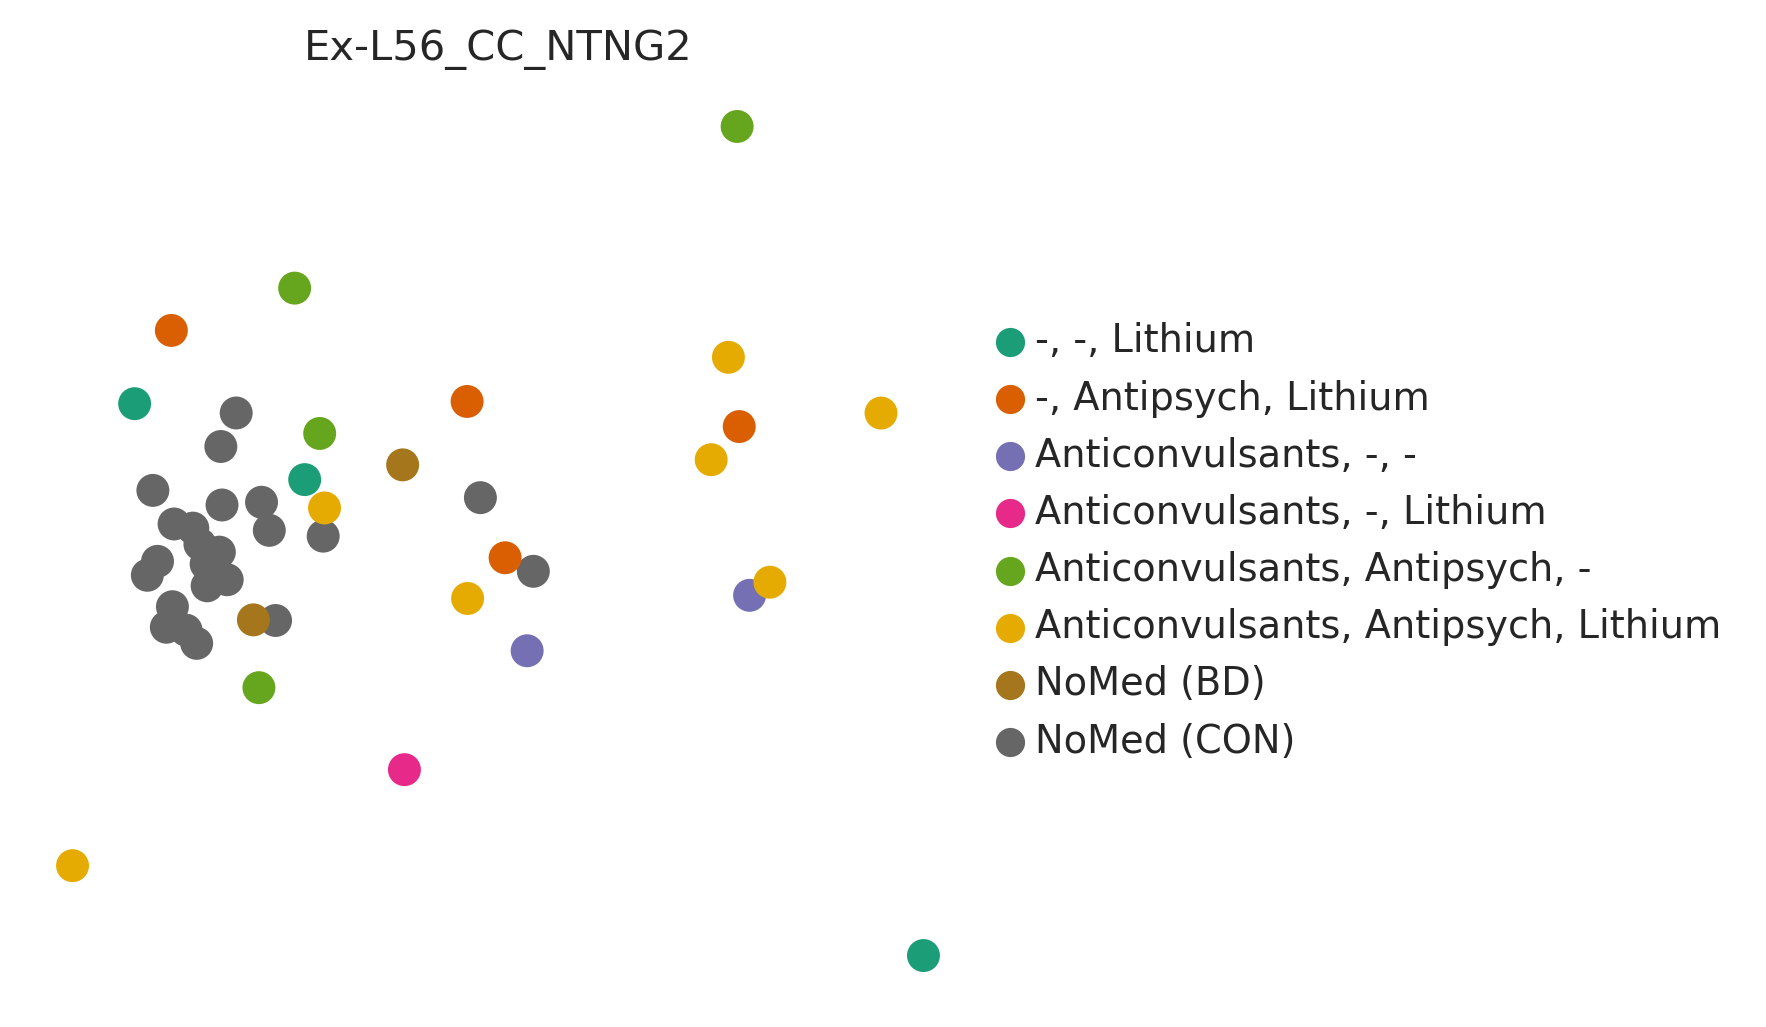

Ex-L5b_HTR2C
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=8.06e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=4.49e-03).
iter 1: alpha=1.41e+00, target_var=1.76e+02, background_var=1.25e+02, contrastive_var=2.47e-01
iter 2: alpha=3.94e+00, target_var=1.22e+02, background_var=3.08e+01, contrastive_var=4.80e-01
iter 3: alpha=1.34e+01, target_var=6.58e+01, background_var=4.84e+00, contrastive_var=8.84e-01
iter 4: alpha=9.40e+01, target_var=3.91e+01, background_var=3.76e-01, contrastive_var=3.67e+00
iter 5: alpha=7.93e+02, target_var=3.03e+01, background_var=7.90e-03, contrastive_var=2.40e+01
iter 6: alpha=9.96e+02, target_var=2.90e+01, background_var=1.14e-04, contrastive_var=2.89e+01
aggregating on .X attribute since no layer specified


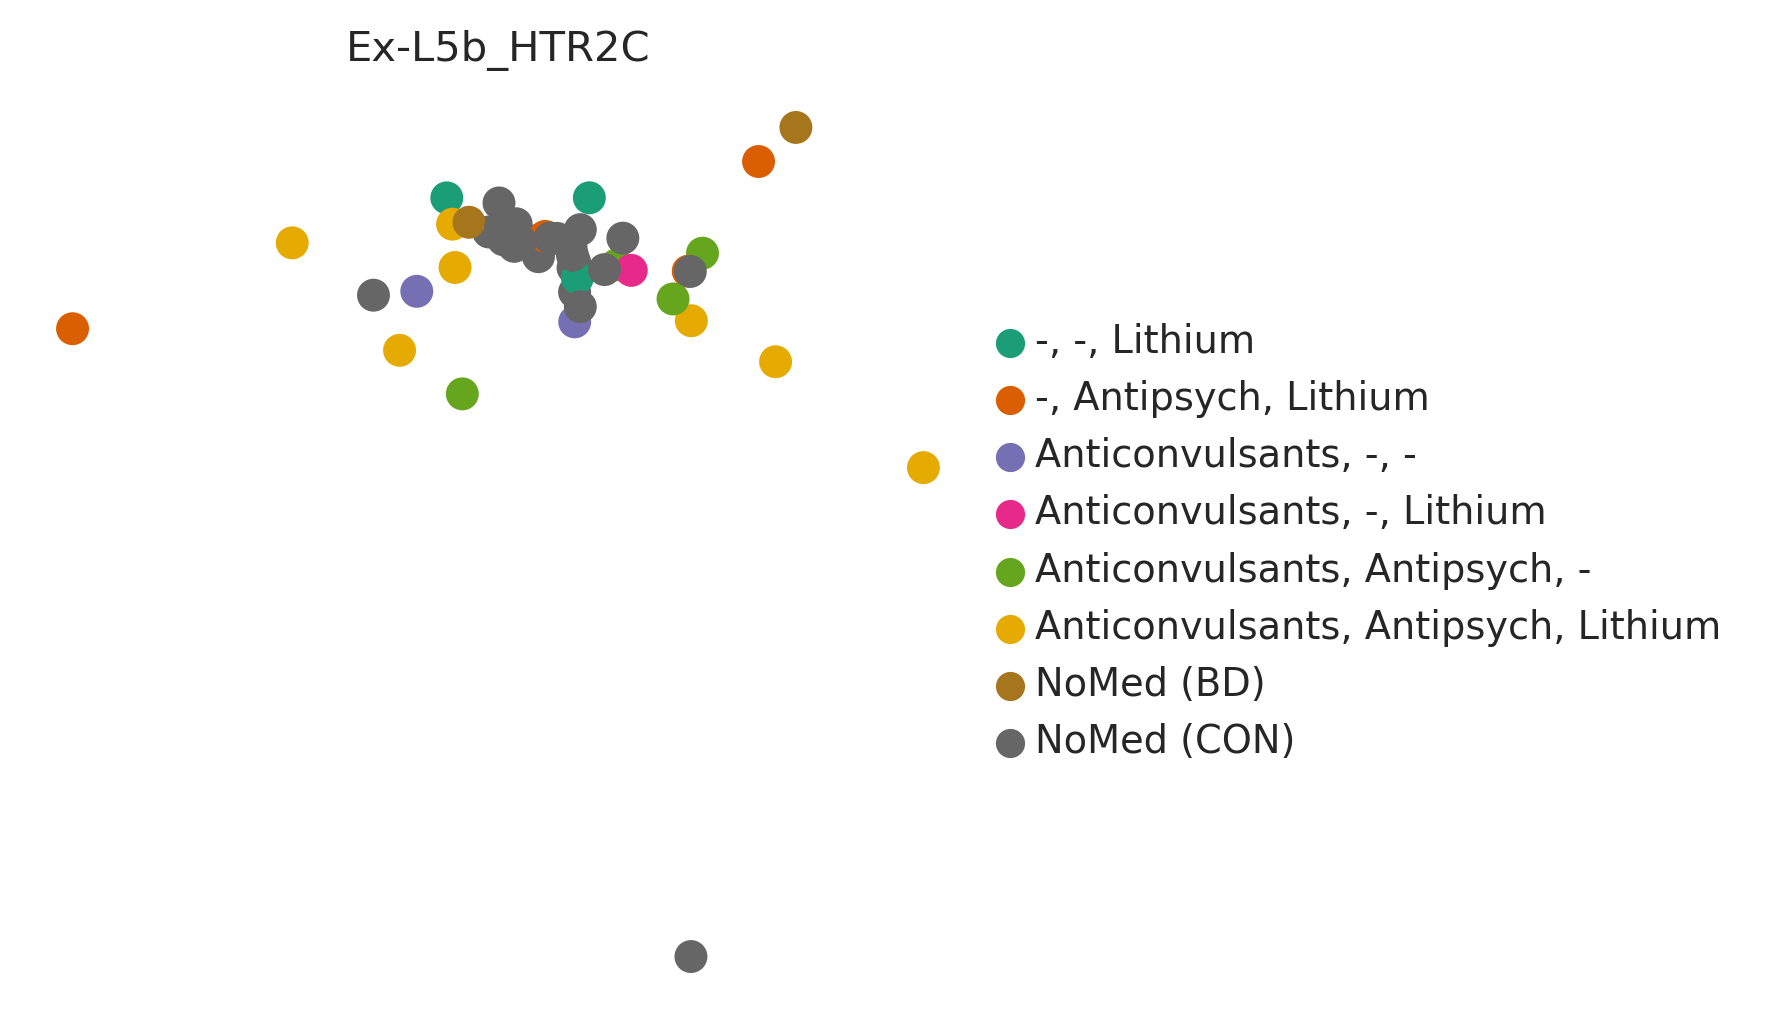

Ex-L6_CC_SEMA3A
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=3.91e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.08e-03).
iter 1: alpha=1.57e+00, target_var=1.47e+03, background_var=9.33e+02, contrastive_var=2.31e+00
iter 2: alpha=5.79e+00, target_var=1.05e+03, background_var=1.80e+02, contrastive_var=6.07e+00
iter 3: alpha=3.10e+01, target_var=6.24e+02, background_var=1.95e+01, contrastive_var=1.94e+01
iter 4: alpha=3.18e+02, target_var=4.37e+02, background_var=9.37e-01, contrastive_var=1.39e+02
iter 5: alpha=9.67e+02, target_var=3.82e+02, background_var=1.30e-02, contrastive_var=3.69e+02
iter 6: alpha=9.96e+02, target_var=3.76e+02, background_var=1.59e-03, contrastive_var=3.75e+02
aggregating on .X attribute since no layer specified


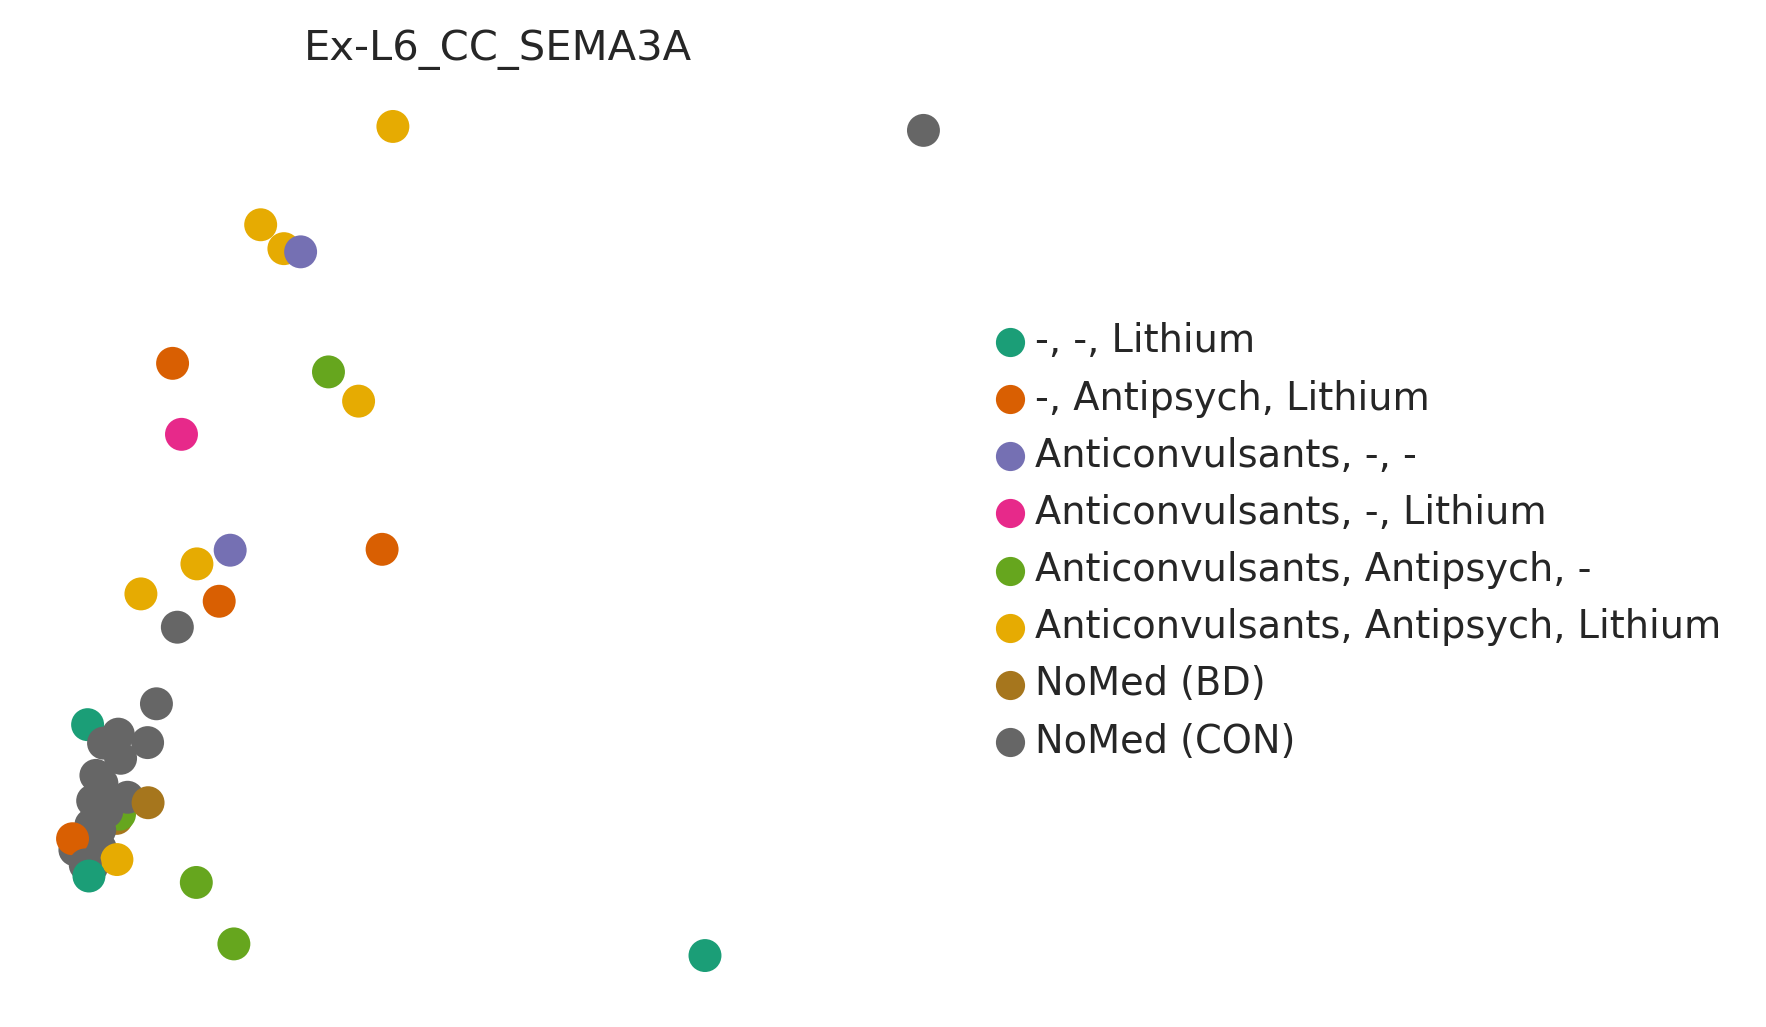

Ex-L6b_SEMA3D
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=6.64e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=8.17e-04).
iter 1: alpha=1.68e+00, target_var=9.91e+02, background_var=5.88e+02, contrastive_var=1.67e+00
iter 2: alpha=6.28e+00, target_var=6.98e+02, background_var=1.10e+02, contrastive_var=4.39e+00
iter 3: alpha=3.45e+01, target_var=4.20e+02, background_var=1.17e+01, contrastive_var=1.45e+01
iter 4: alpha=3.69e+02, target_var=2.97e+02, background_var=5.08e-01, contrastive_var=1.09e+02
iter 5: alpha=9.76e+02, target_var=2.63e+02, background_var=6.36e-03, contrastive_var=2.57e+02
iter 6: alpha=9.96e+02, target_var=2.60e+02, background_var=1.00e-03, contrastive_var=2.59e+02
aggregating on .X attribute since no layer specified


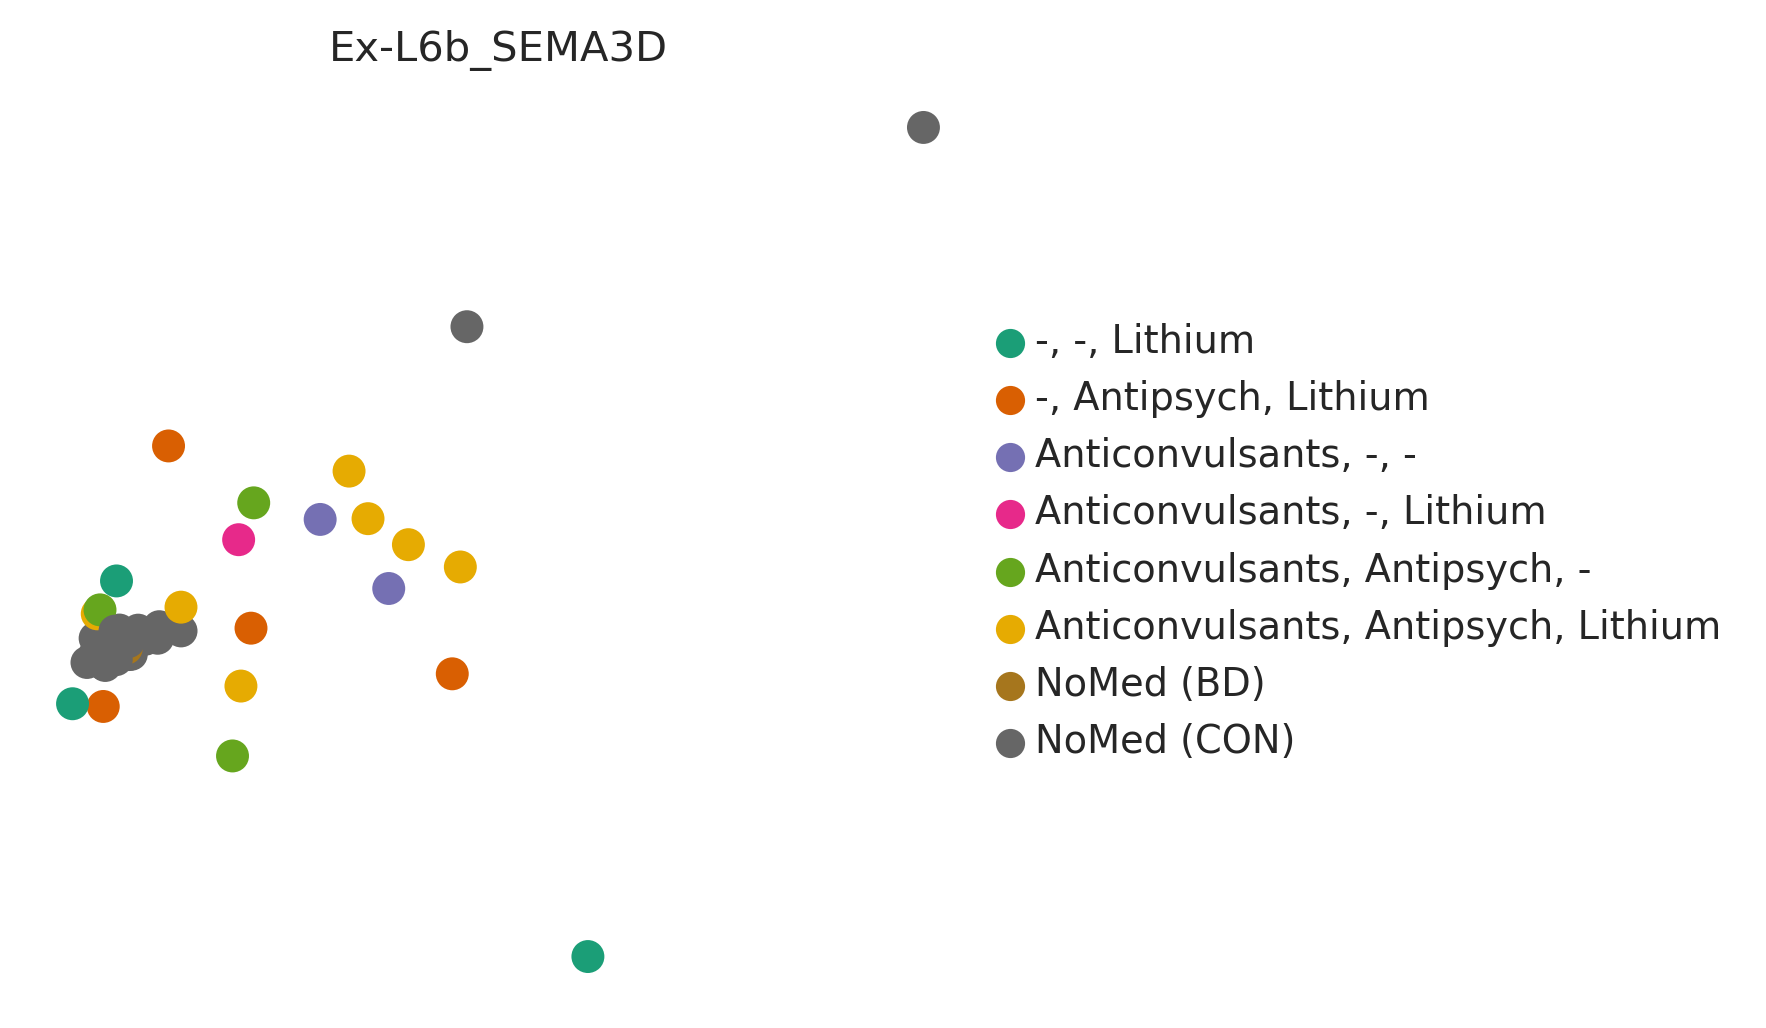

Ex-L6b_SEMA3E
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.54e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.79e-03).
iter 1: alpha=1.63e+00, target_var=6.36e+02, background_var=3.89e+02, contrastive_var=1.04e+00
iter 2: alpha=5.79e+00, target_var=4.43e+02, background_var=7.61e+01, contrastive_var=2.56e+00
iter 3: alpha=3.08e+01, target_var=2.64e+02, background_var=8.28e+00, contrastive_var=8.13e+00
iter 4: alpha=3.25e+02, target_var=1.84e+02, background_var=3.83e-01, contrastive_var=5.98e+01
iter 5: alpha=9.70e+02, target_var=1.62e+02, background_var=5.01e-03, contrastive_var=1.57e+02
iter 6: alpha=9.96e+02, target_var=1.60e+02, background_var=6.29e-04, contrastive_var=1.59e+02
aggregating on .X attribute since no layer specified


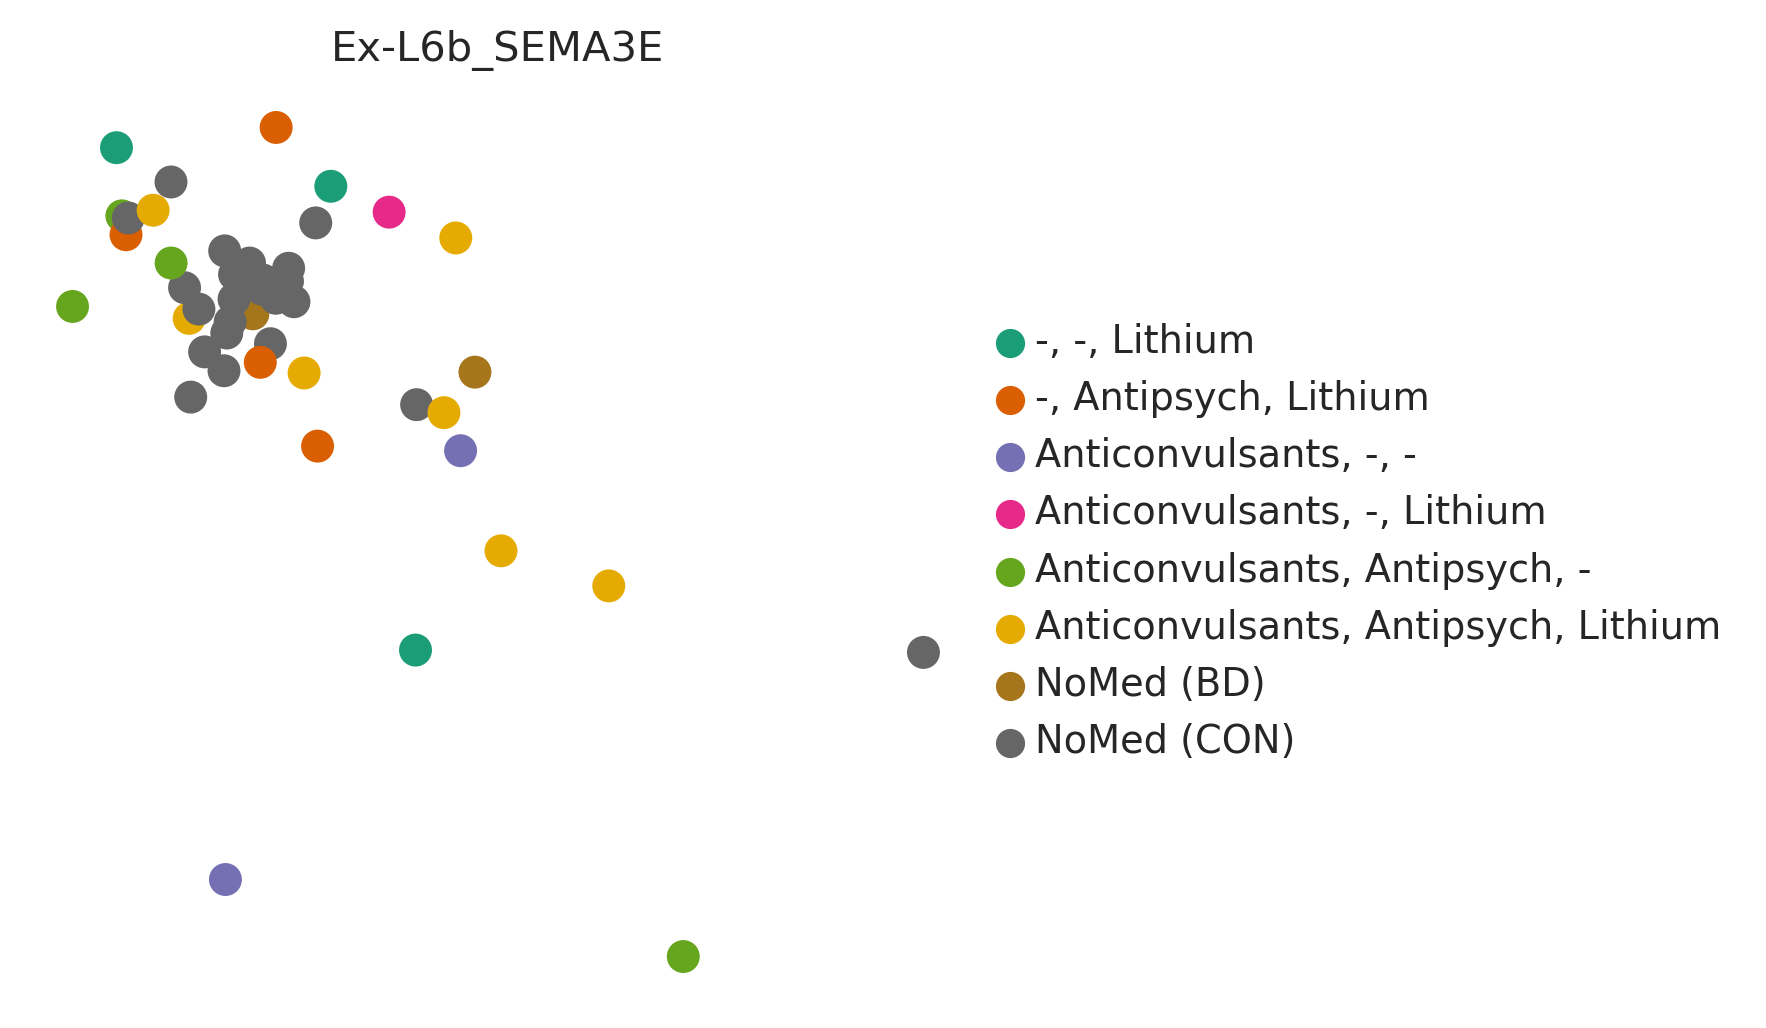

In-PV_Basket
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.54e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=3.99e-03).
iter 1: alpha=1.34e+00, target_var=5.42e+02, background_var=4.04e+02, contrastive_var=7.27e-01
iter 2: alpha=3.50e+00, target_var=3.66e+02, background_var=1.04e+02, contrastive_var=1.28e+00
iter 3: alpha=1.11e+01, target_var=1.92e+02, background_var=1.72e+01, contrastive_var=2.13e+00
iter 4: alpha=6.99e+01, target_var=1.10e+02, background_var=1.46e+00, contrastive_var=7.65e+00
iter 5: alpha=6.47e+02, target_var=8.22e+01, background_var=4.48e-02, contrastive_var=5.32e+01
iter 6: alpha=9.92e+02, target_var=7.65e+01, background_var=6.09e-04, contrastive_var=7.59e+01
aggregating on .X attribute since no layer specified


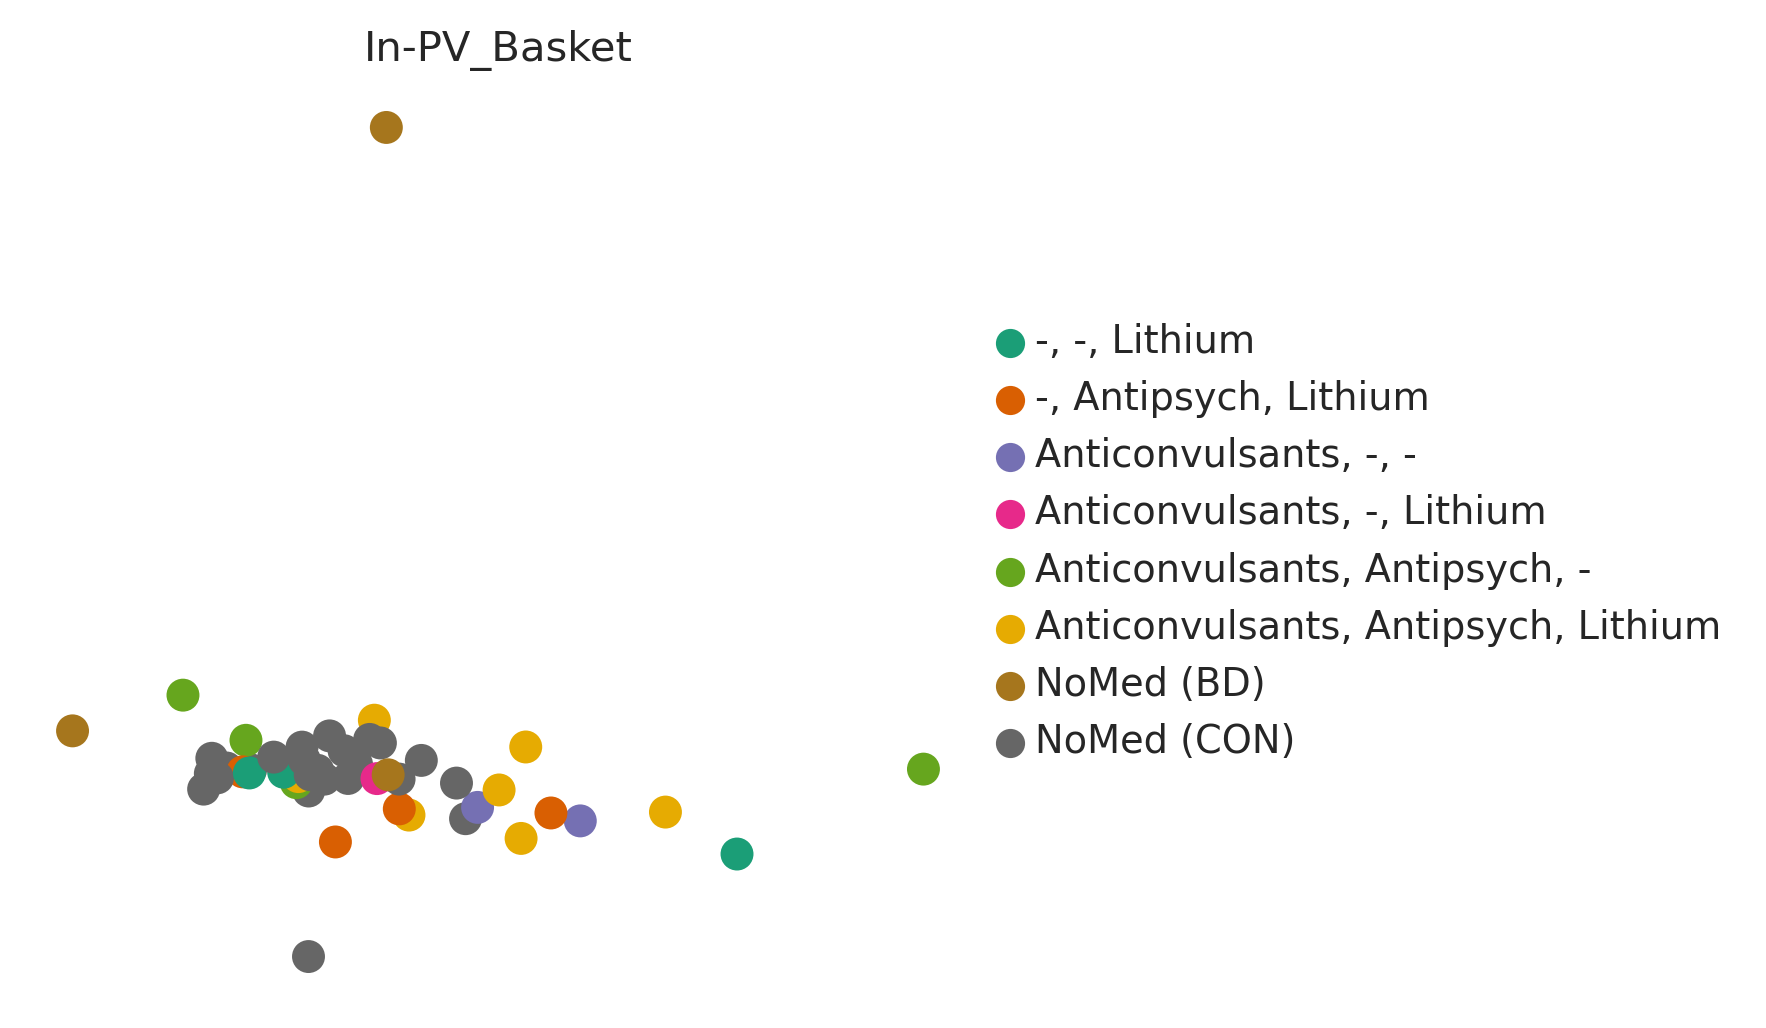

In-PV_Chandelier
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.65e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.95e-03).
iter 1: alpha=1.12e+00, target_var=6.47e+01, background_var=5.75e+01, contrastive_var=7.25e-02
iter 2: alpha=2.27e+00, target_var=4.26e+01, background_var=1.87e+01, contrastive_var=9.69e-02
iter 3: alpha=4.50e+00, target_var=2.06e+01, background_var=4.55e+00, contrastive_var=9.26e-02
iter 4: alpha=1.01e+01, target_var=1.07e+01, background_var=1.05e+00, contrastive_var=1.07e-01
iter 5: alpha=1.23e+01, target_var=8.36e+00, background_var=6.72e-01, contrastive_var=1.03e-01
aggregating on .X attribute since no layer specified


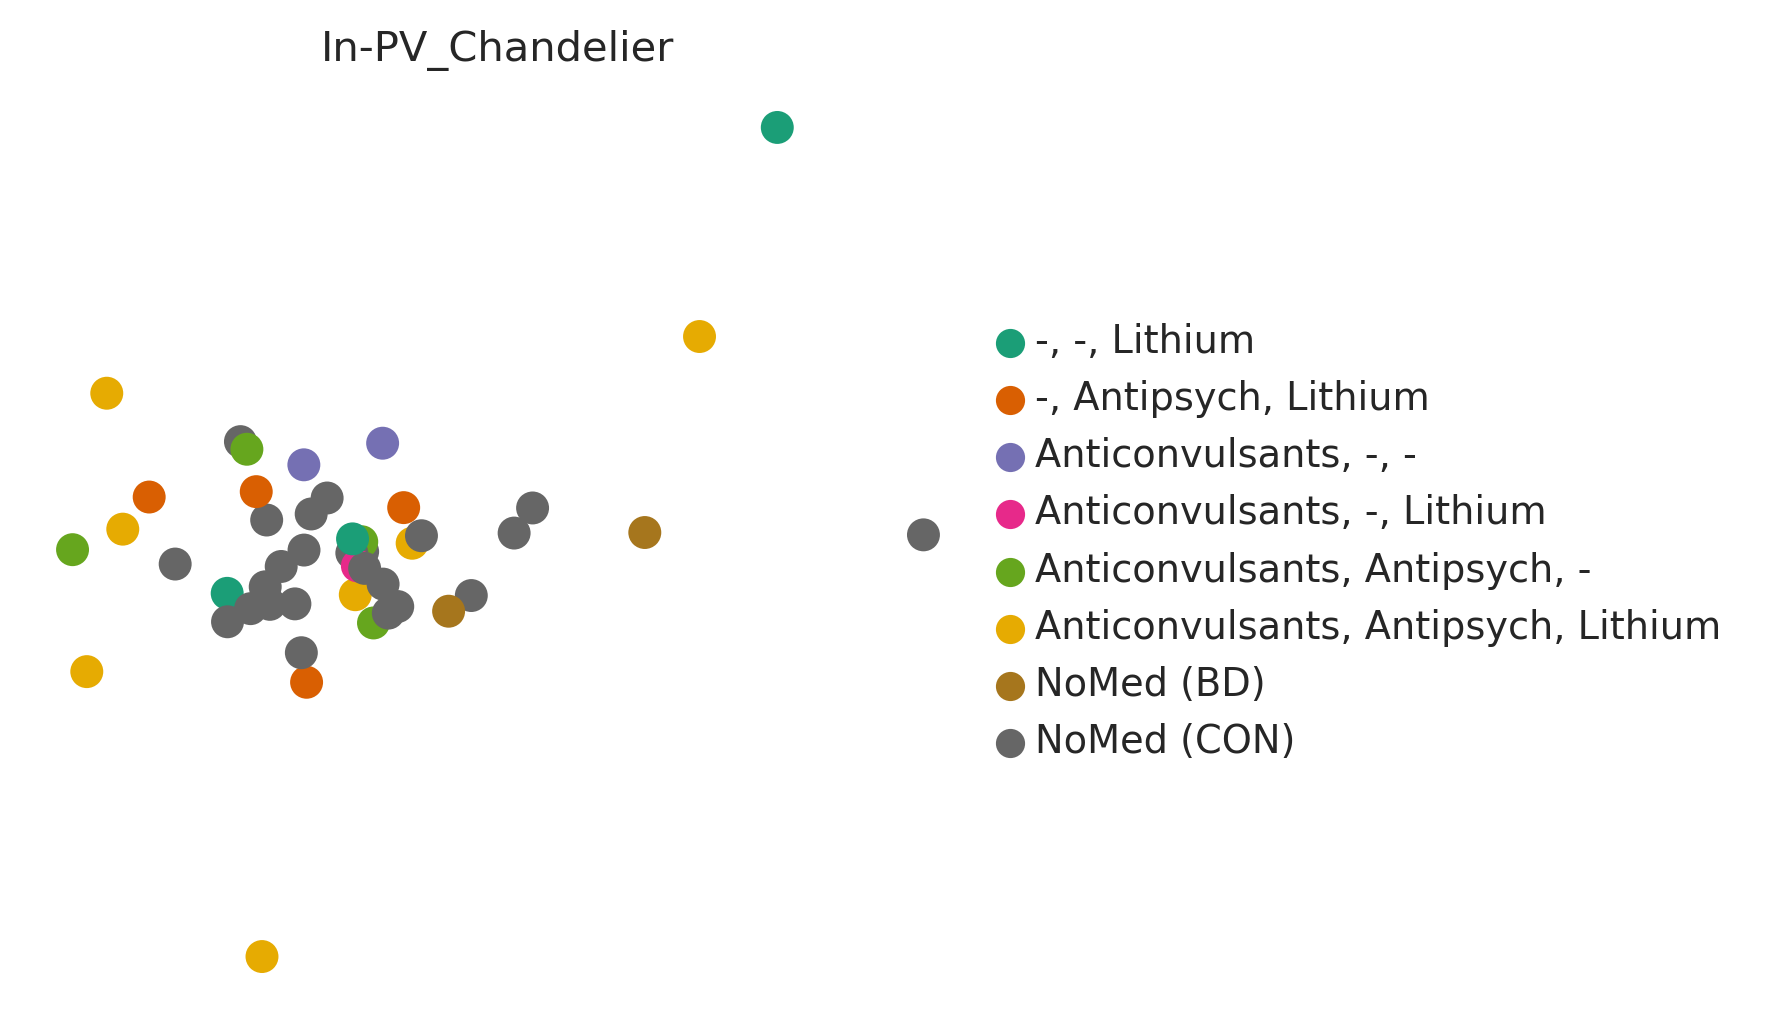

In-Reelin
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.69e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=2.92e-03).
iter 1: alpha=1.40e+00, target_var=2.76e+02, background_var=1.96e+02, contrastive_var=3.87e-01
iter 2: alpha=3.92e+00, target_var=1.83e+02, background_var=4.66e+01, contrastive_var=7.19e-01
iter 3: alpha=1.37e+01, target_var=1.00e+02, background_var=7.19e+00, contrastive_var=1.37e+00
iter 4: alpha=1.01e+02, target_var=6.01e+01, background_var=5.34e-01, contrastive_var=6.07e+00
iter 5: alpha=8.07e+02, target_var=4.67e+01, background_var=1.11e-02, contrastive_var=3.77e+01
iter 6: alpha=9.96e+02, target_var=4.47e+01, background_var=1.98e-04, contrastive_var=4.45e+01
aggregating on .X attribute since no layer specified


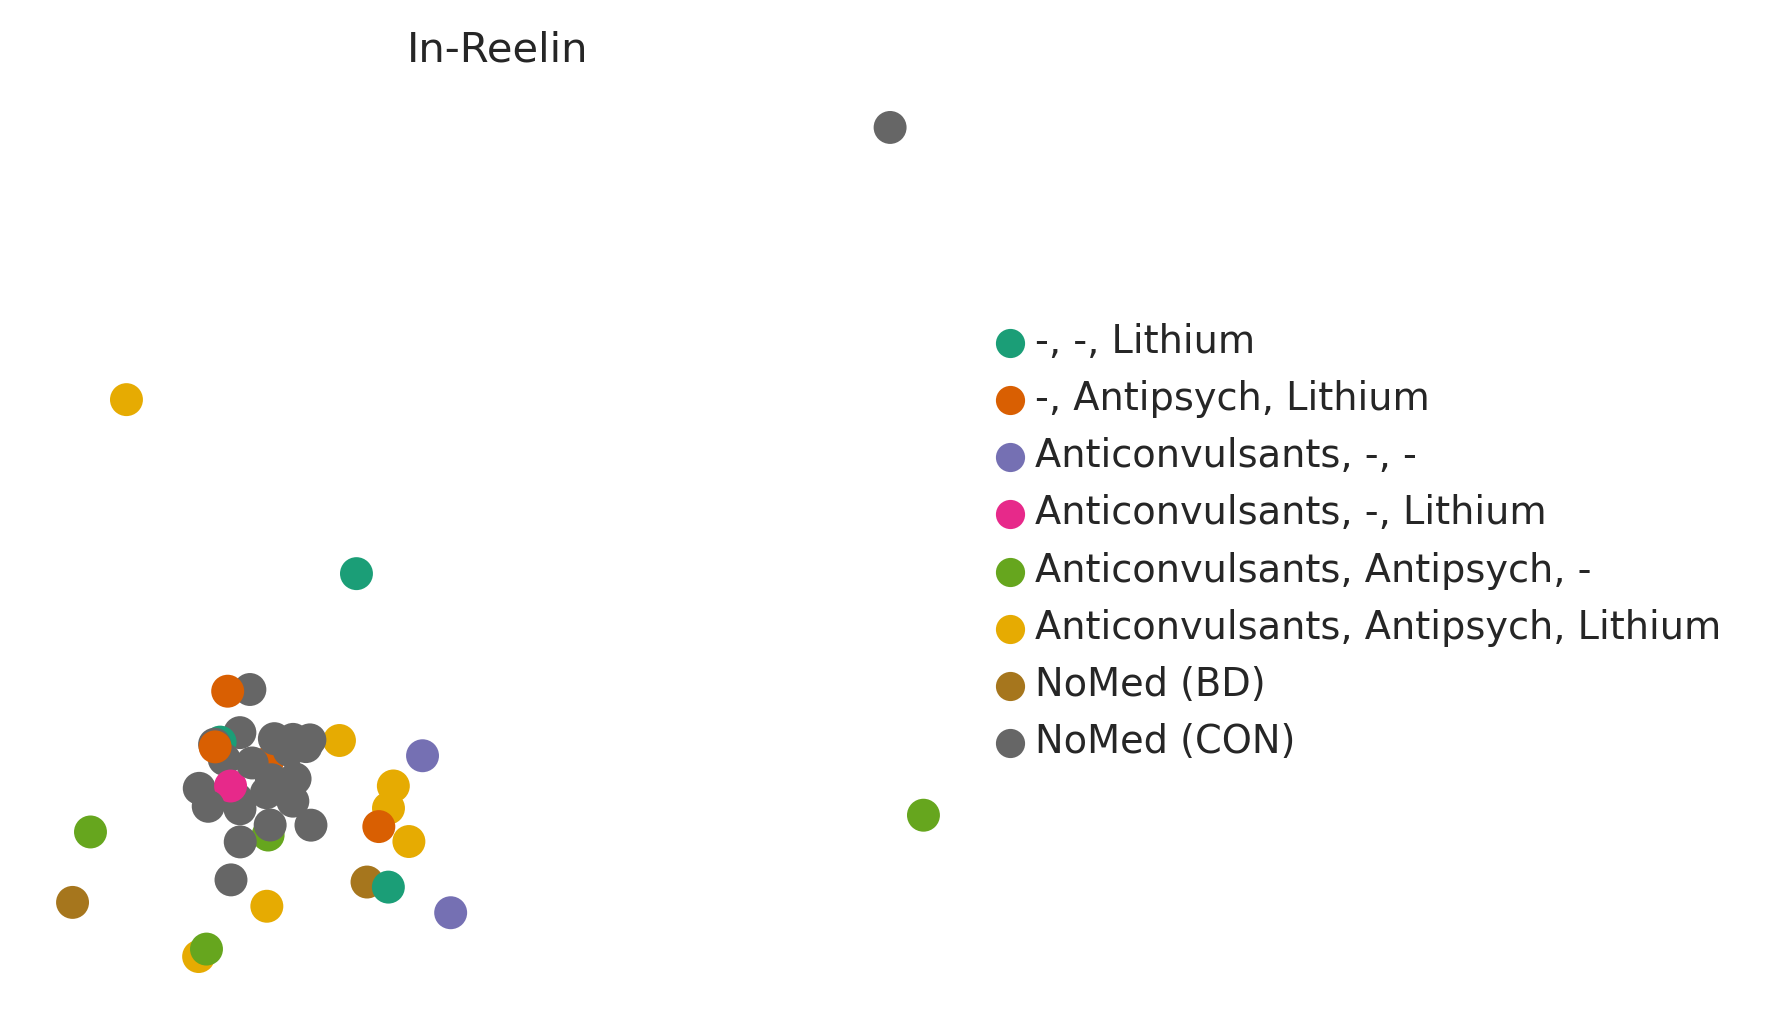

In-Rosehip_CHST9
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=4.17e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=4.92e-03).
iter 1: alpha=1.36e+00, target_var=1.65e+02, background_var=1.22e+02, contrastive_var=2.25e-01
iter 2: alpha=3.91e+00, target_var=1.14e+02, background_var=2.89e+01, contrastive_var=4.44e-01
iter 3: alpha=1.35e+01, target_var=6.17e+01, background_var=4.52e+00, contrastive_var=8.32e-01
iter 4: alpha=9.98e+01, target_var=3.68e+01, background_var=3.32e-01, contrastive_var=3.68e+00
iter 5: alpha=7.78e+02, target_var=2.84e+01, background_var=8.13e-03, contrastive_var=2.21e+01
iter 6: alpha=9.94e+02, target_var=2.70e+01, background_var=1.50e-04, contrastive_var=2.68e+01
aggregating on .X attribute since no layer specified


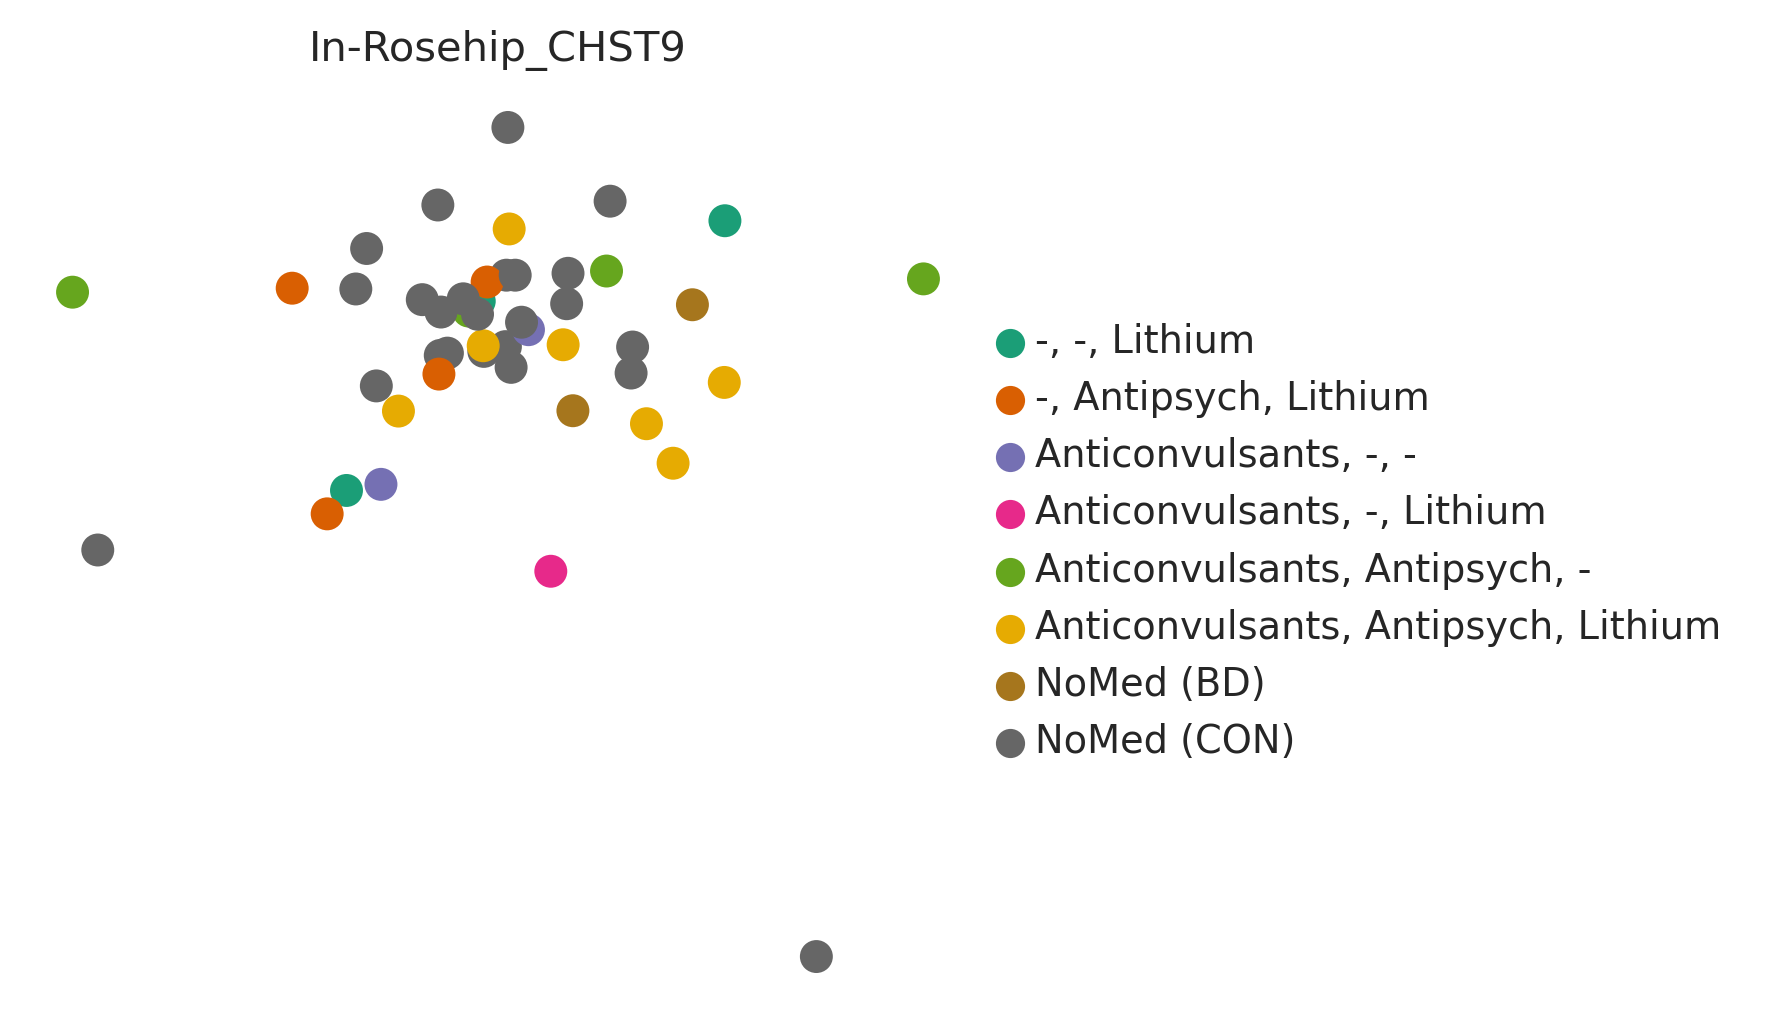

In-Rosehip_TRPC3
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=2.62e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=2.22e-03).
iter 1: alpha=1.35e+00, target_var=2.53e+02, background_var=1.86e+02, contrastive_var=3.42e-01
iter 2: alpha=4.20e+00, target_var=1.68e+02, background_var=3.98e+01, contrastive_var=7.05e-01
iter 3: alpha=1.74e+01, target_var=9.50e+01, background_var=5.37e+00, contrastive_var=1.65e+00
iter 4: alpha=1.50e+02, target_var=6.15e+01, background_var=3.47e-01, contrastive_var=9.25e+00
iter 5: alpha=8.89e+02, target_var=5.05e+01, background_var=6.33e-03, contrastive_var=4.49e+01
iter 6: alpha=9.95e+02, target_var=4.89e+01, background_var=2.32e-04, contrastive_var=4.87e+01
aggregating on .X attribute since no layer specified


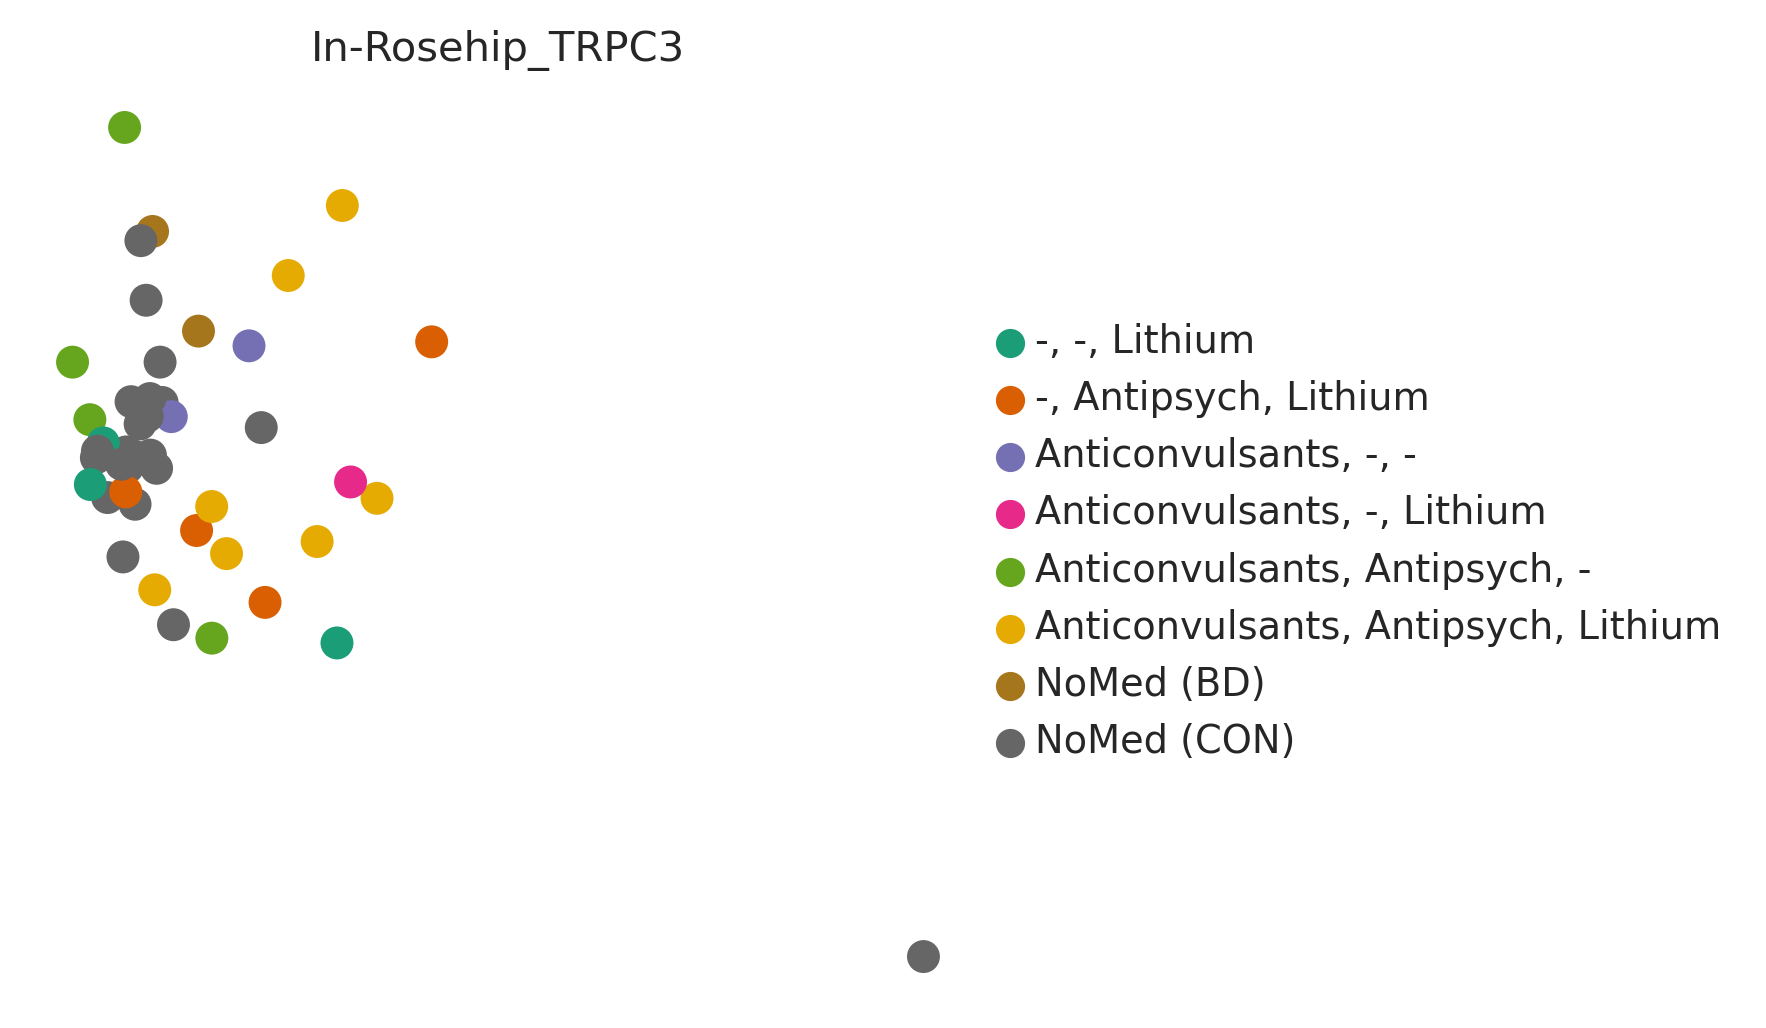

In-SST
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=8.79e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=8.37e-03).
iter 1: alpha=1.24e+00, target_var=3.12e+02, background_var=2.52e+02, contrastive_var=3.86e-01
iter 2: alpha=2.76e+00, target_var=2.01e+02, background_var=7.27e+01, contrastive_var=5.56e-01
iter 3: alpha=6.85e+00, target_var=1.01e+02, background_var=1.46e+01, contrastive_var=6.93e-01
iter 4: alpha=2.54e+01, target_var=5.23e+01, background_var=2.01e+00, contrastive_var=1.33e+00
iter 5: alpha=1.91e+02, target_var=3.26e+01, background_var=1.38e-01, contrastive_var=6.23e+00
iter 6: alpha=8.88e+02, target_var=2.68e+01, background_var=3.36e-03, contrastive_var=2.38e+01
iter 7: alpha=9.95e+02, target_var=2.56e+01, background_var=1.26e-04, contrastive_var=2.55e+01
aggregating on .X attribute since no layer specified


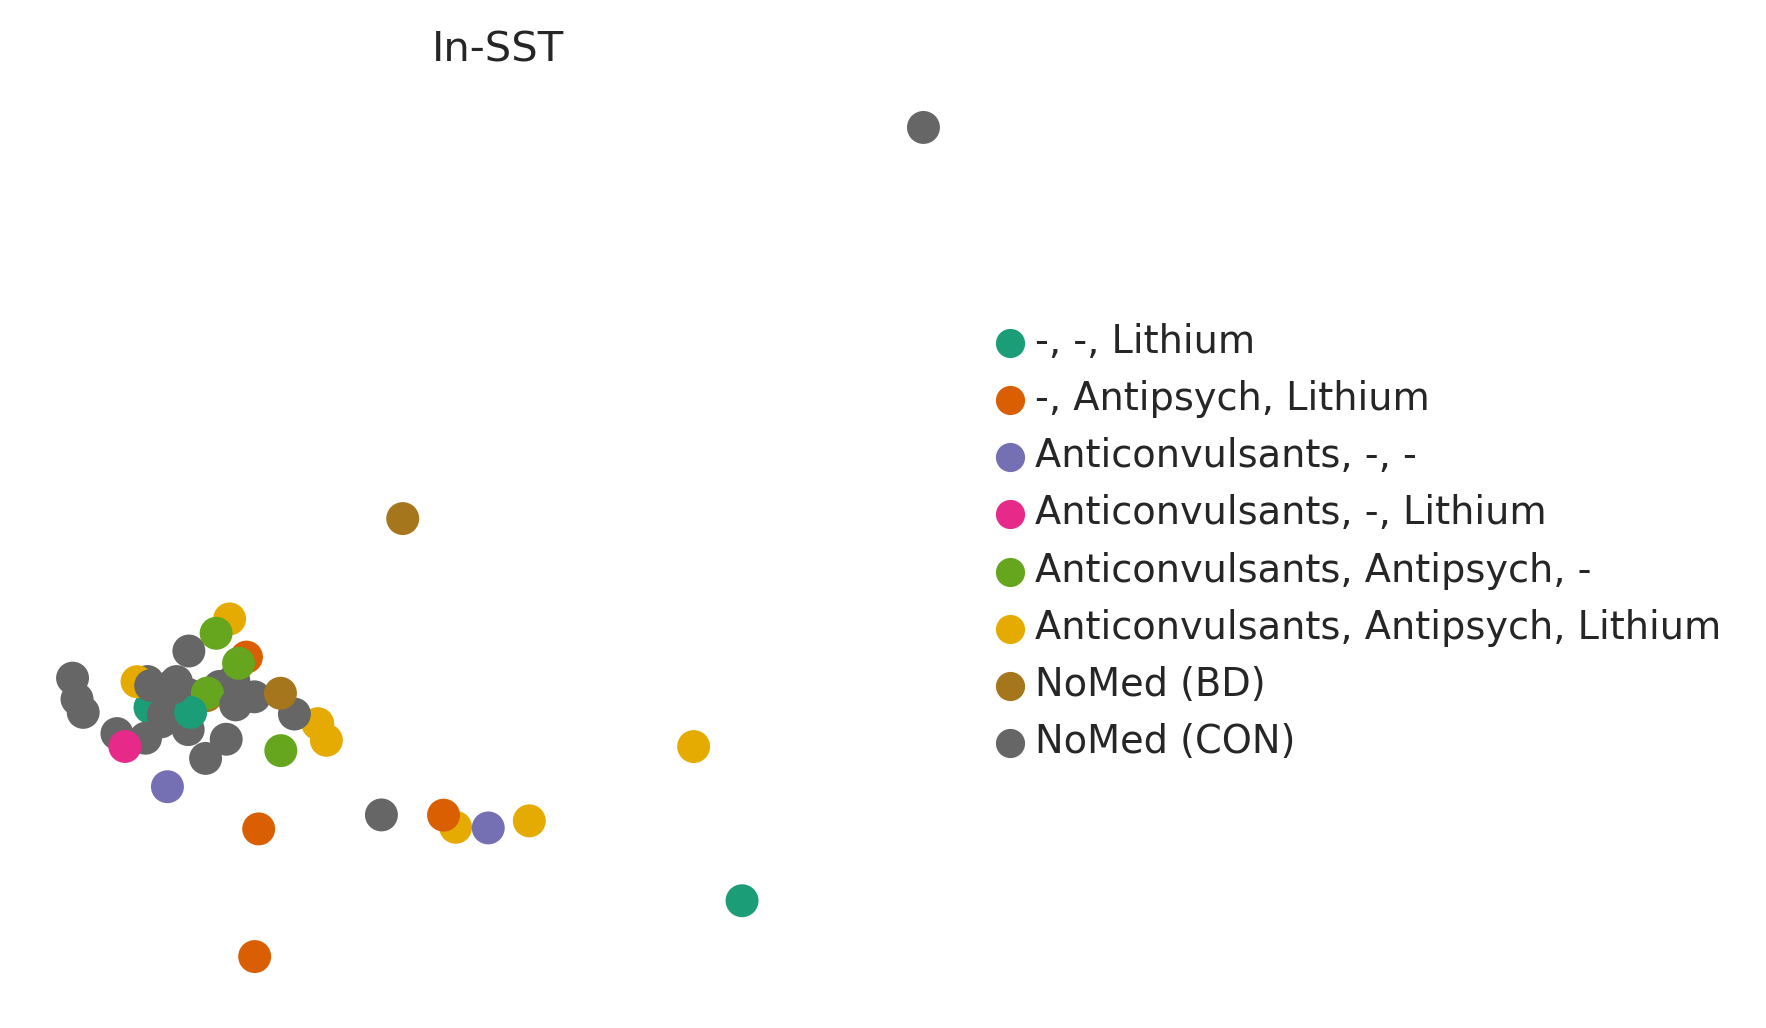

In-VIP
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=2.62e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=4.50e-03).
iter 1: alpha=1.24e+00, target_var=3.77e+02, background_var=3.03e+02, contrastive_var=4.68e-01
iter 2: alpha=3.01e+00, target_var=2.47e+02, background_var=8.19e+01, contrastive_var=7.45e-01
iter 3: alpha=8.56e+00, target_var=1.26e+02, background_var=1.46e+01, contrastive_var=1.08e+00
iter 4: alpha=4.32e+01, target_var=6.82e+01, background_var=1.51e+00, contrastive_var=2.94e+00
iter 5: alpha=4.39e+02, target_var=4.70e+01, background_var=6.01e-02, contrastive_var=2.06e+01
iter 6: alpha=9.84e+02, target_var=4.21e+01, background_var=6.99e-04, contrastive_var=4.14e+01
iter 7: alpha=9.97e+02, target_var=4.17e+01, background_var=1.42e-04, contrastive_var=4.16e+01
aggregating on .X attribute since no layer specified


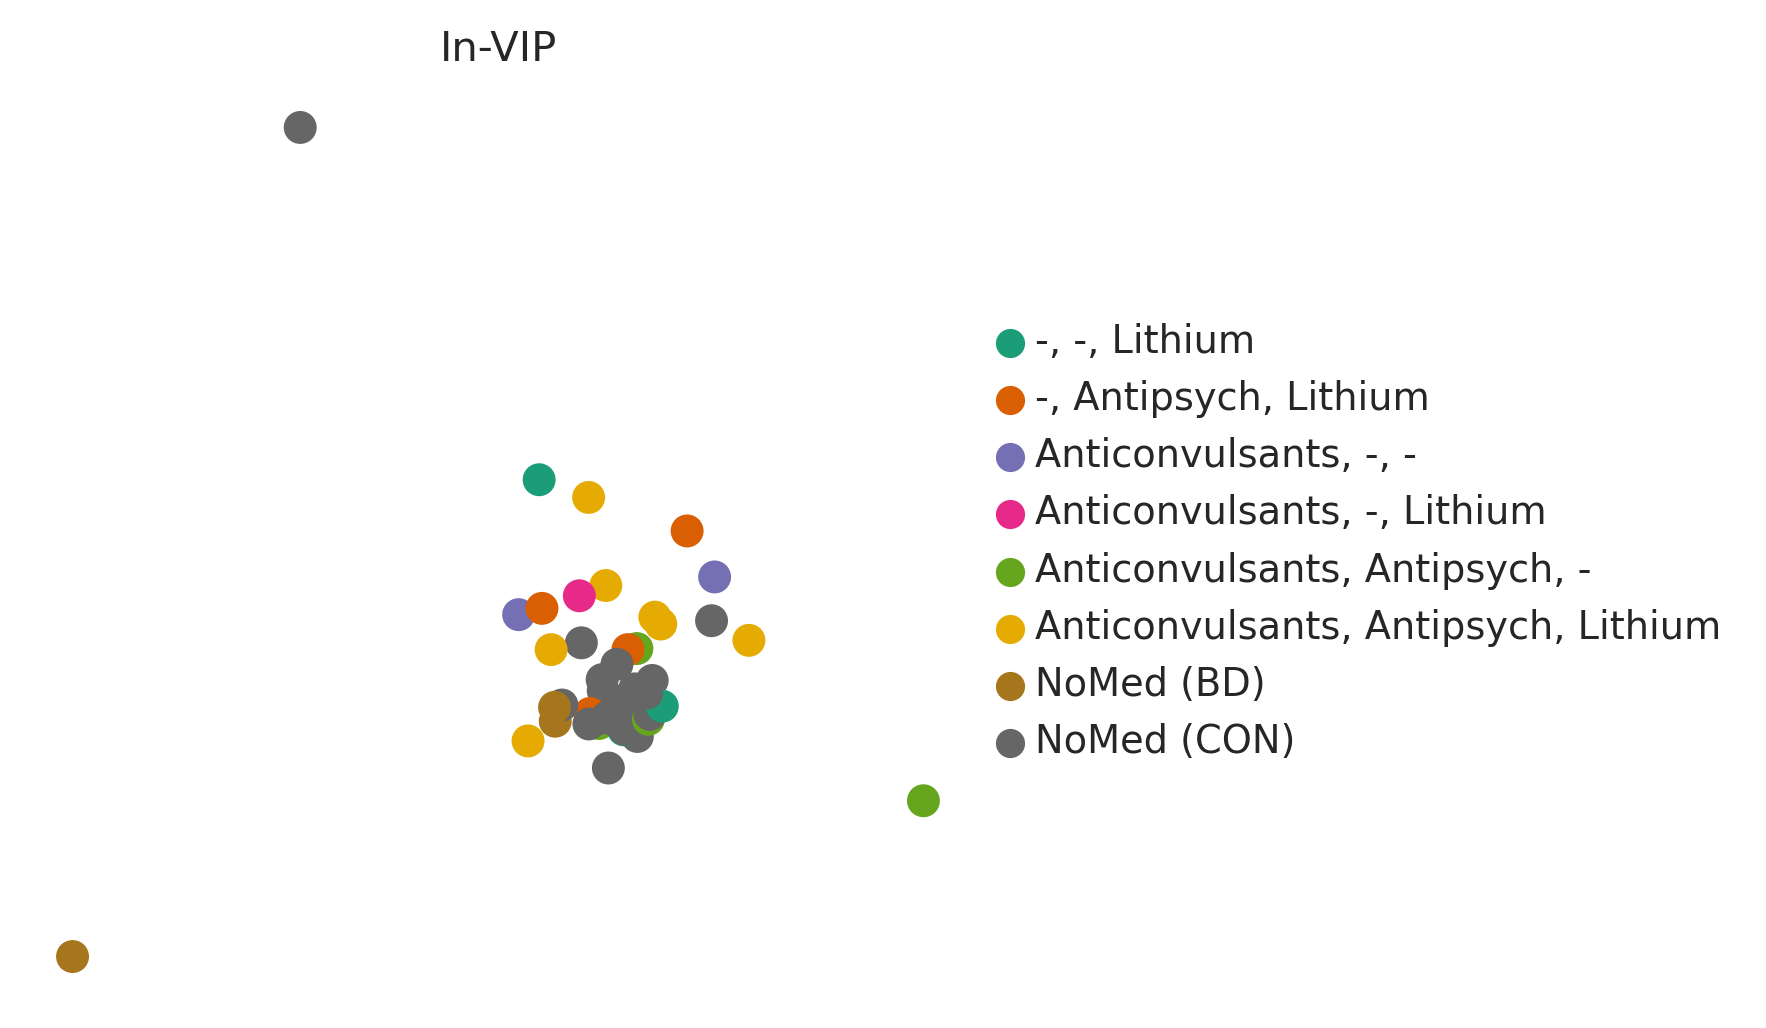

Mic
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.22e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=5.34e-03).
iter 1: alpha=9.23e-01, target_var=3.97e+01, background_var=4.30e+01, contrastive_var=3.67e-02
iter 2: alpha=2.27e+00, target_var=2.59e+01, background_var=1.14e+01, contrastive_var=5.90e-02
iter 3: alpha=6.99e+00, target_var=1.38e+01, background_var=1.96e+00, contrastive_var=9.64e-02
iter 4: alpha=1.84e+01, target_var=9.20e+00, background_var=4.92e-01, contrastive_var=1.69e-01
iter 5: alpha=1.96e+01, target_var=8.57e+00, background_var=4.29e-01, contrastive_var=1.68e-01
aggregating on .X attribute since no layer specified


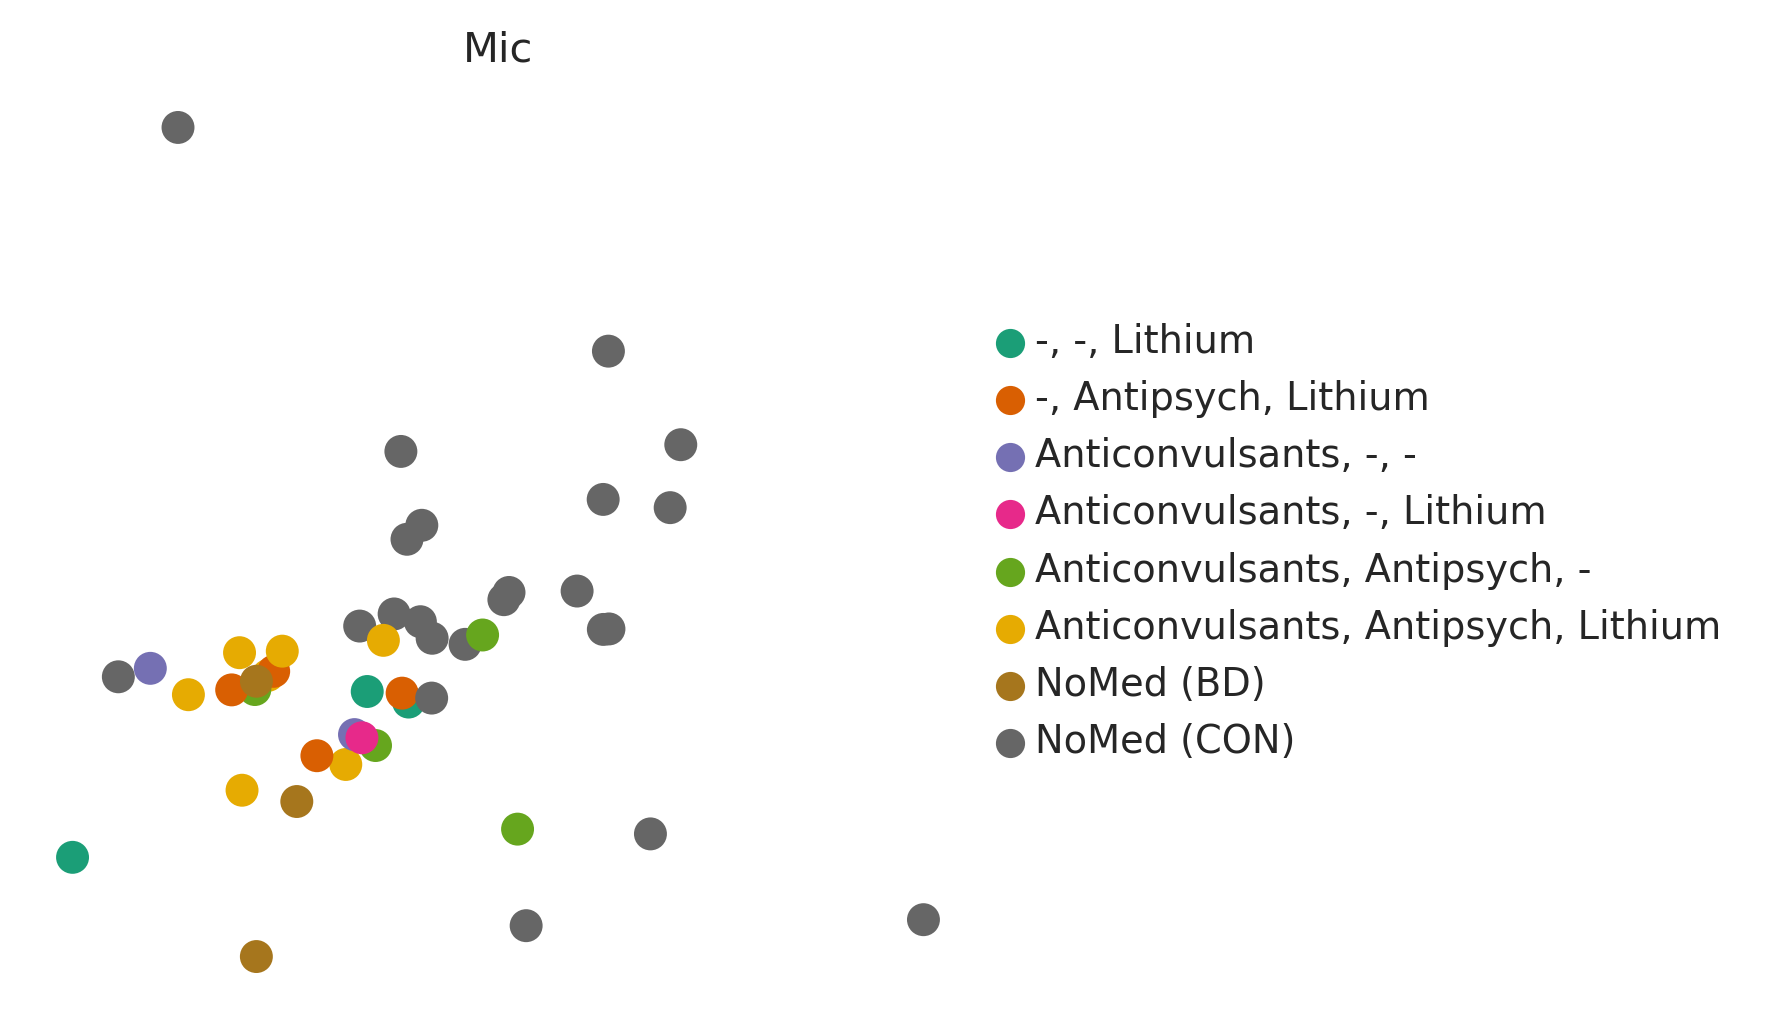

OPC
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=5.25e-04).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=2.09e-03).
iter 1: alpha=1.03e+00, target_var=1.51e+02, background_var=1.46e+02, contrastive_var=1.56e-01
iter 2: alpha=2.28e+00, target_var=1.01e+02, background_var=4.43e+01, contrastive_var=2.31e-01
iter 3: alpha=5.25e+00, target_var=5.07e+01, background_var=9.60e+00, contrastive_var=2.66e-01
iter 4: alpha=1.84e+01, target_var=2.49e+01, background_var=1.33e+00, contrastive_var=4.57e-01
iter 5: alpha=1.78e+02, target_var=1.49e+01, background_var=6.85e-02, contrastive_var=2.65e+00
iter 6: alpha=9.62e+02, target_var=1.22e+01, background_var=4.83e-04, contrastive_var=1.17e+01
iter 7: alpha=9.99e+02, target_var=1.21e+01, background_var=1.72e-05, contrastive_var=1.21e+01
aggregating on .X attribute since no layer specified


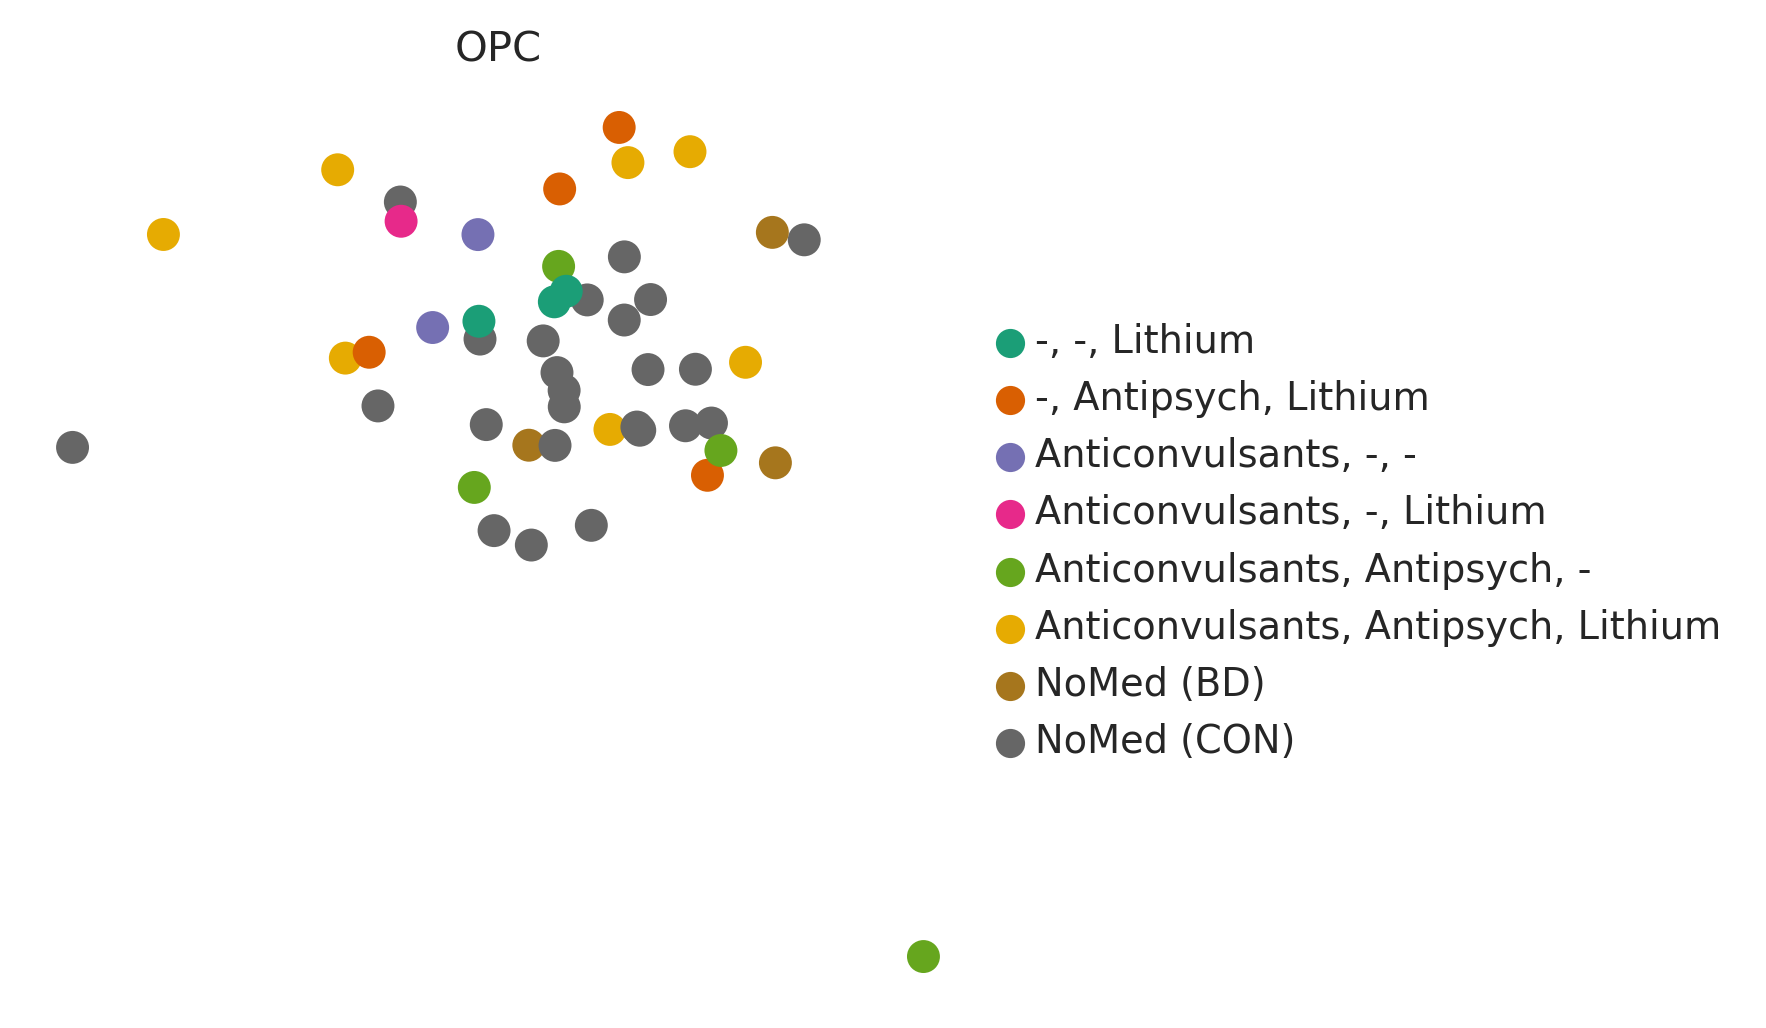

Oli
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=1.48e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=2.49e-03).
iter 1: alpha=9.99e-01, target_var=9.29e+01, background_var=9.29e+01, contrastive_var=9.27e-02
iter 2: alpha=1.39e+00, target_var=5.30e+01, background_var=3.80e+01, contrastive_var=7.39e-02
iter 3: alpha=1.82e+00, target_var=2.41e+01, background_var=1.32e+01, contrastive_var=4.39e-02
iter 4: alpha=2.04e+00, target_var=1.58e+01, background_var=7.73e+00, contrastive_var=3.23e-02
aggregating on .X attribute since no layer specified


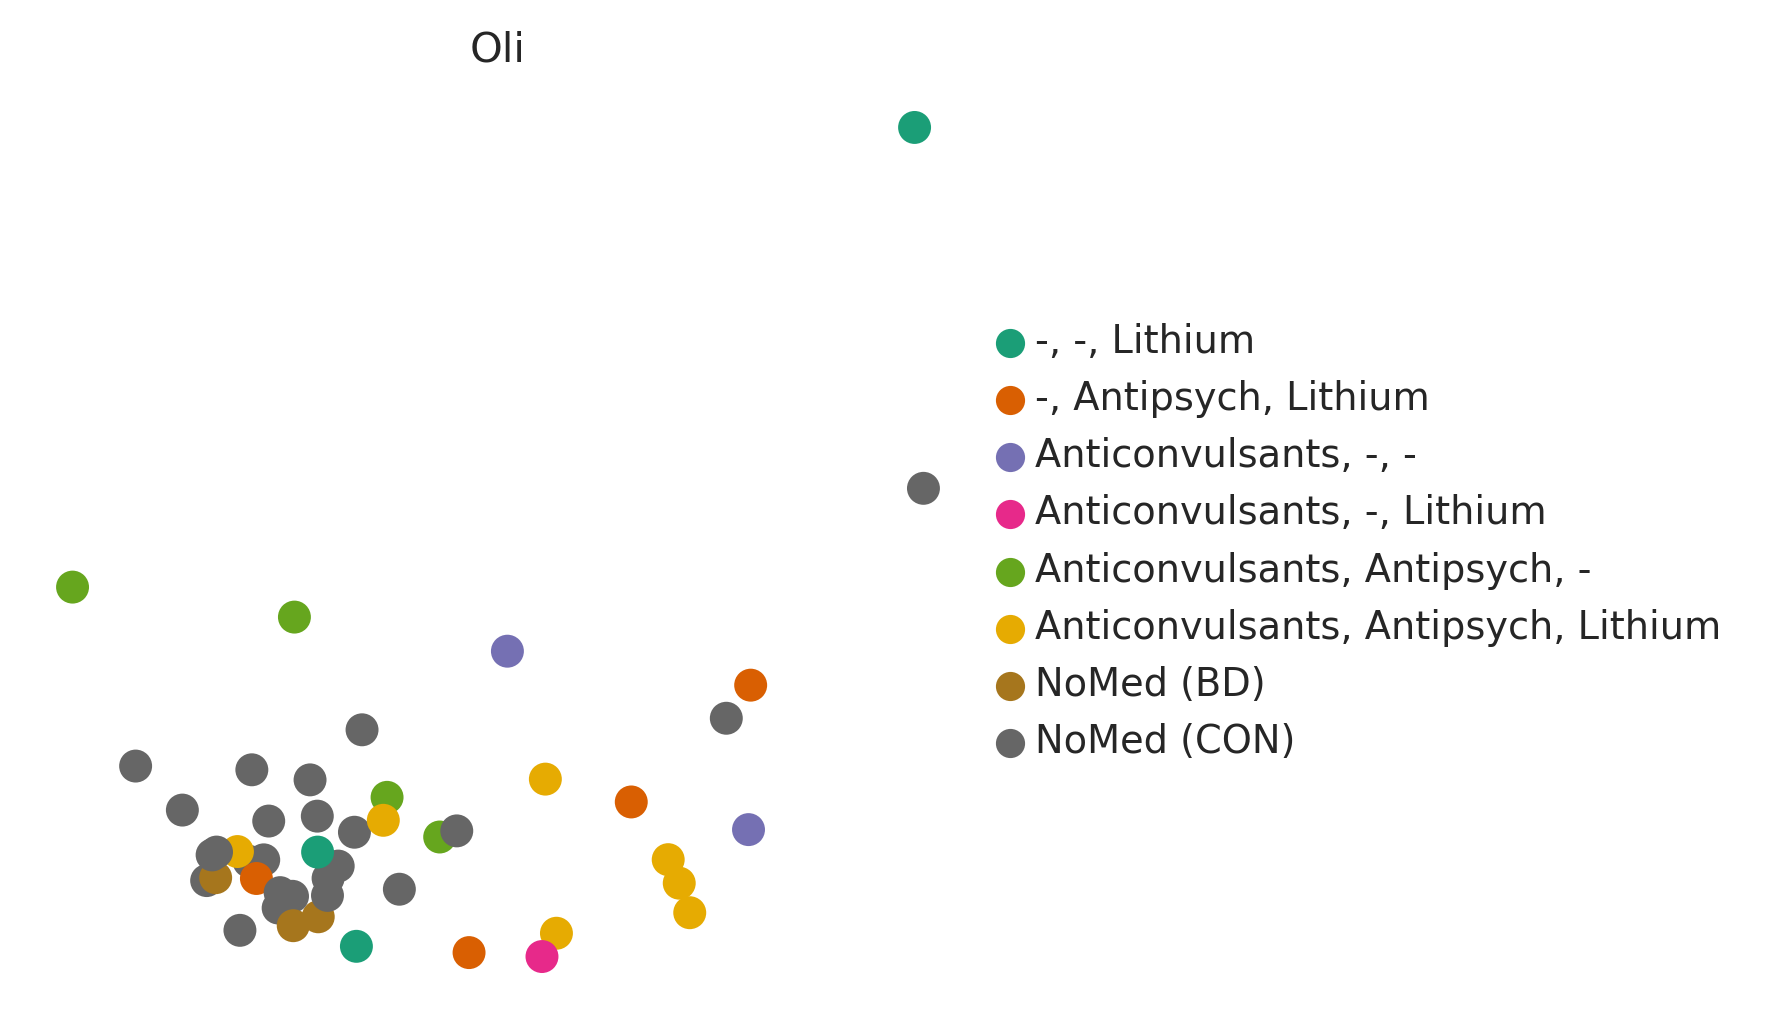

Pericytes
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=7.84e-03).
Iteration 0
Iteration 1
Iteration 2
IRLS converged after 3 iterations (delta=3.71e-03).
iter 1: alpha=1.06e+00, target_var=5.24e+01, background_var=4.92e+01, contrastive_var=5.57e-02
iter 2: alpha=4.48e+00, target_var=3.98e+01, background_var=8.84e+00, contrastive_var=1.78e-01
iter 3: alpha=2.39e+01, target_var=2.40e+01, background_var=9.79e-01, contrastive_var=5.74e-01
iter 4: alpha=2.12e+02, target_var=1.68e+01, background_var=6.26e-02, contrastive_var=3.56e+00
iter 5: alpha=8.94e+02, target_var=1.41e+01, background_var=1.68e-03, contrastive_var=1.26e+01
iter 6: alpha=9.91e+02, target_var=1.36e+01, background_var=1.30e-04, contrastive_var=1.34e+01
aggregating on .X attribute since no layer specified


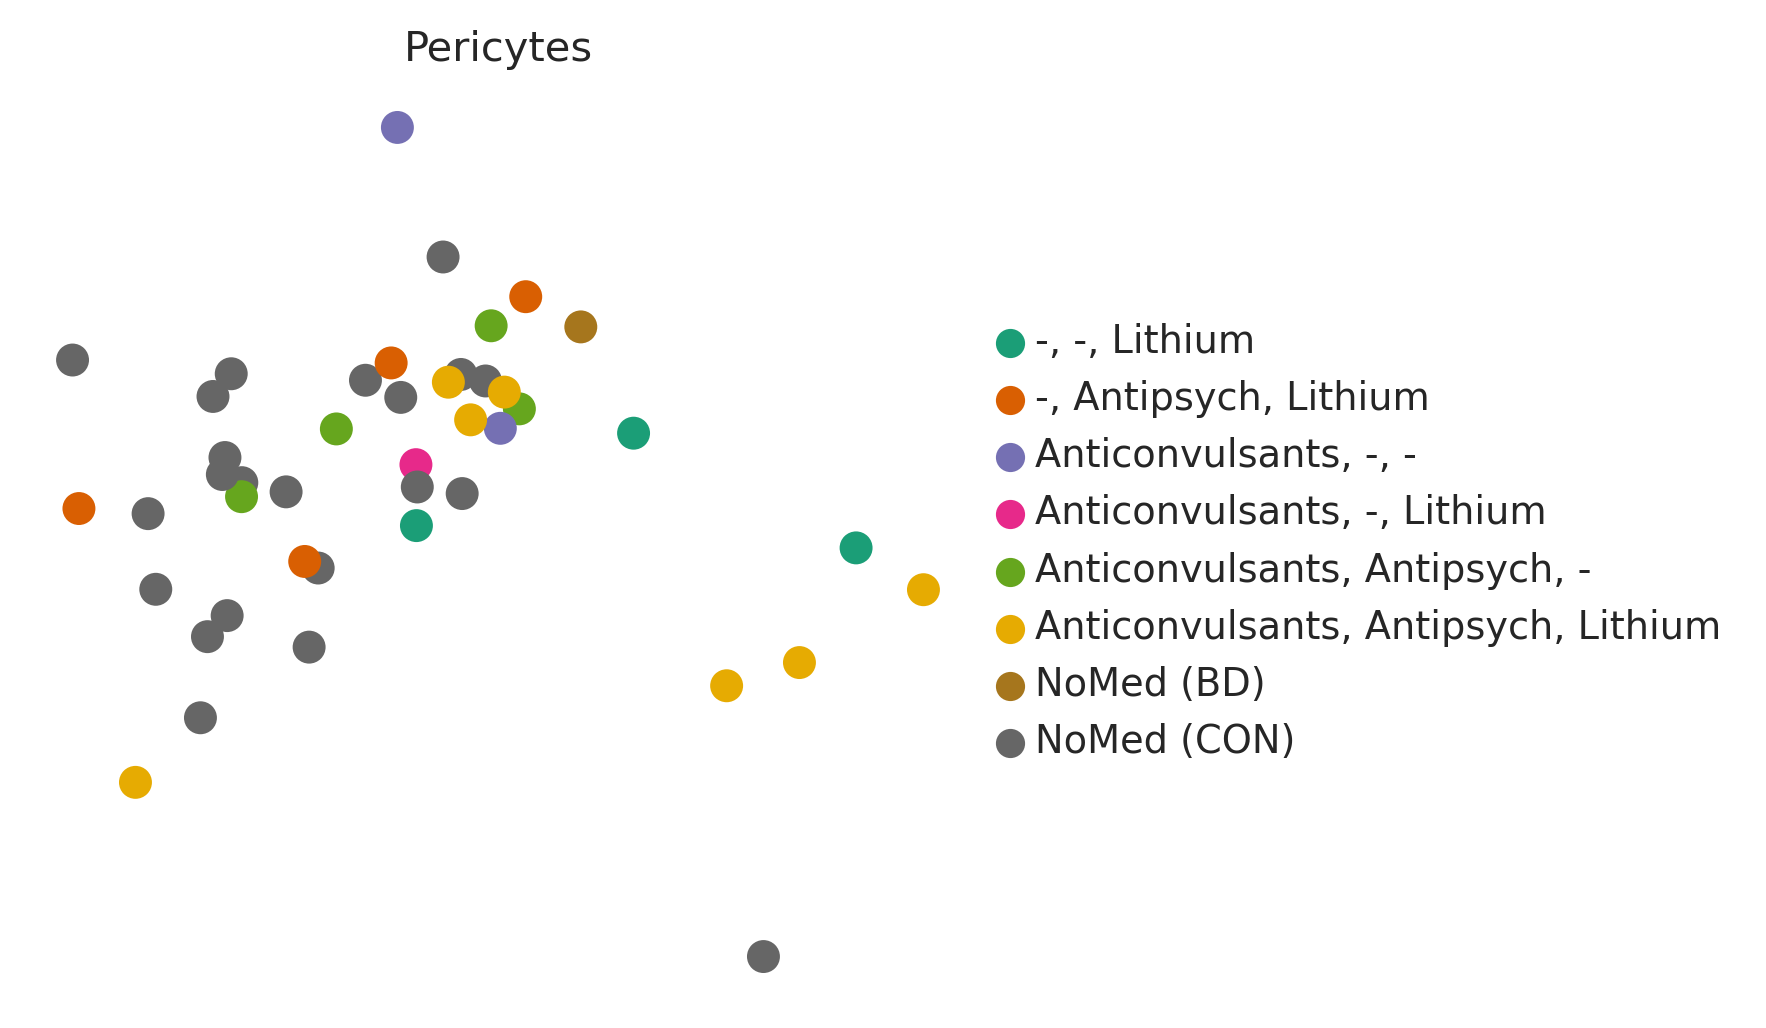

In [6]:
pb_adata_dict = {}
trace_dict = {}
sc_cpca = scCPCA(n_components=3)

for celltype in celltypes:
    print(celltype)
    adata = sc.read_h5ad(f'{dataset_path}/{cohort}/h5ad/{celltype}.h5ad')
    DE_gene_mask = adata.var_names.isin(DE_tbl.loc[(DE_tbl["cell_type"] == celltype) & (DE_tbl["bdDEG_MASTRE"] == 1), "gene"])
    adata_DE = adata[:, DE_gene_mask].copy()

    # Fit constastive axes on single-cell data
    sc_cpca.fit(target=adata_DE[adata_DE.obs["Phenotype"] == "BD", :], background=adata_DE[adata_DE.obs["Phenotype"] == "CON", :])

    # Construct pseudobulk samples
    adata_DE_pb = compute_pseudobulk(adata_DE, grouping_var_key="SubID", normalization_method="lib_size_norm")
    adata_DE_pb.obs = metadata_tbl.loc[adata_DE_pb.obs_names, :].copy()
    
    # Project pseudobulk profiles on the contrastive axes
    adata_DE_pb = sc_cpca.transform(adata_DE_pb)
    adata_DE_pb.varm["cPCA"] = sc_cpca.components.copy()
    adata_DE_pb.write_h5ad(f"{celltype}_cpca.h5ad")
    
    sc.pl.embedding(adata_DE_pb, color='Medication', basis="X_cPCA", title=celltype, palette="Dark2", cmap = "RdYlBu", frameon=False, show = True, save = "_" + celltype + ".png", ncols = 1, size = 250)
    pb_adata_dict[celltype] = adata_DE_pb
    
    # Plot and store traces
    adata_DE_pb_trace = sc_cpca.get_projection_trace(adata=adata_DE_pb, copy=True)
    for key in adata_DE_pb_trace.obsm.keys():
        sc.pl.embedding(
            adata_DE_pb_trace,
            basis=key,
            color="Medication",
            title=key,
            cmap="RdYlBu",
            palette="Dark2",
            size=250,
            frameon=False,
            ncols=1,
            show = False, save = "_" + celltype + ".png"        
        )
    trace_dict[celltype] = adata_DE_pb_trace